5/20 (Mon) | Experiment <br>
6/13 (Thu) | Edited

# Evaluation of Predictability of Automatically Calculated UF Measures

## 1. Introduction

This notebook evaluate the reliability of the UF measures calculated based on the proposed annotation system. More specifically, I construct linear models to predict PF for each task.

The input variables are follows:
- Speed fluency
    - Articulation rate (AR)
- Breakdown fluency
    - Mid-clause pause ratio (MCPR)
    - End-clause pause ratio (ECPR)
    - Mid-clause pause duration (MCPD)
    - End-clause pause duration (ECPD)
    - Pause ratio (PR)
    - Pause duration (PD)
- Repair fluency
    - Disfluency ratio (DR)
- Composite
    - Speech rate (SR)
    - Mean length of run (MLR)

The output variable is logit value which is calculated by Many Facet Rasch model (i.e., raters' severity is removed).

Linear regressions are employed as prediction models.
The dataset is divided into training and testing at a ratio of 8:2 taking distribution into account.
For the model construction, because of relatively small data size, I utilize the stratified 5-fold cross validation technique.
The models are evaluated in terms of Pearon's correlation coefficient and $R^2$ score.

Before starting the evaluation, the following code block loads required packages and define global variables.

In [1]:
from typing import Tuple, Dict, Optional, List, Generator
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from scipy.stats import pearsonr
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from relativeImp import relativeImp

from utils.mfr import logit_2_rating

DATA_DIR = Path("/home/matsuura/Development/app/feature_extraction_api/experiment/data")

TASK = ["Arg_Oly", "Cartoon", "RtSwithoutRAA", "RtSwithRAA", "WoZ_Interview"]

TARGET_UF_MEASURES = [
    "articulation_rate", "mid_clause_pause_ratio", "end_clause_pause_ratio",
    "mid_clause_p-dur", "end_clause_p-dur", "pause_ratio", "mean_pause_duration",
    "dysfluency_ratio", "speech_rate", "mean_length_of_run"
]

RANDOM_STATE = 0

---

## 2. Define Functions

This section defines functions for the analyses.
The following code block defines functions to load a dataset including UF measures and logit value.

In [2]:
def add_pause_ratio(df_uf: pd.DataFrame) -> pd.DataFrame:
    df_uf.loc[:, "pause_ratio"] = df_uf["mid_clause_pause_ratio"] + df_uf["end_clause_pause_ratio"]

    return df_uf

def calculate_mean_uf_measures(df_uf: pd.DataFrame) -> pd.DataFrame:
    data = []

    for uid in range(1, 86):
        uid = str(uid).zfill(3)

        mask = df_uf.index.str.startswith(uid)
        if mask.sum() == 0:
            continue

        df_uf_masked = df_uf[mask]
        mean_uf_measures = df_uf_masked.mean(axis=0, skipna=True)
        
        row = {
            "uid": uid   
        }
        for measure_name in df_uf.columns:
            row[measure_name] = mean_uf_measures[measure_name]
        data.append(row)

    df_uf_mean = pd.DataFrame.from_dict(data).set_index("uid", drop=True)

    return df_uf_mean

def load_dataset(task: str, manual: bool =True, task_facet: bool =False) -> Tuple[pd.DataFrame, pd.DataFrame]:
    if manual:
        uf_path = DATA_DIR / f"{task}/09_UF_Measures/uf_measures_manu_pruned.csv"
    else:
        uf_path = DATA_DIR / f"{task}/09_UF_Measures/uf_measures_auto_pruned.csv"

    df_uf = pd.read_csv(uf_path, index_col="uid")

    if task == "WoZ_Interview":
        df_uf = calculate_mean_uf_measures(df_uf)

    df_uf = add_pause_ratio(df_uf)

    X = df_uf[TARGET_UF_MEASURES].sort_index()

    pf_path = DATA_DIR / f"{task}/12_PF_Rating/pf_rating.csv"
    df_pf = pd.read_csv(pf_path)
    uid_list = df_pf["uid"].to_numpy()

    if task_facet:
        logit_path = pf_path.parent / "logit_all.csv"
        threshold_path = logit_path.parent / "threshold_all.csv"
    else:
        logit_path = pf_path.parent / "logit.csv"
        threshold_path = logit_path.parent / "threshold.csv"
    
    df_logit = pd.read_csv(logit_path, index_col=0)
    logit = df_logit["theta"].to_numpy()
    rating_list = logit_2_rating(df_logit["theta"], threshold_path)

    data = np.array([uid_list, logit, rating_list]).T
    columns = ["uid", "logit", "rating"]

    Y = pd.DataFrame(data, columns=columns).set_index("uid", drop=True).sort_index()

    return X, Y

The following code block defines a function to conduct correlation analyses between UF measures and logit value.

In [3]:
def correlation_analysis(task: str, X: pd.DataFrame, Y: pd.DataFrame, manual: bool =True) -> pd.DataFrame:
    fig = plt.figure(figsize=(15, 10))
    ncols = 4
    nrows = (len(TARGET_UF_MEASURES) + ncols - 1) // ncols

    data = []
    columns = ["UF measures", "r", "p", "sig"]
    y = Y["logit"]
    for i, measure in enumerate(TARGET_UF_MEASURES):
        ax = fig.add_subplot(nrows, ncols, i + 1)

        x = X[measure]

        r, p = pearsonr(x, y)
        if p < 0.001:
            sig = "***"
        elif p < 0.01:
            sig = "**"
        elif p < 0.05:
            sig = "*"
        elif p < 0.1:
            sig = "."
        else:
            sig = ""

        data.append([measure, r, p, sig])

        ax.scatter(x, y)
        ax.set_title(f"[{measure}] r={r:.03f}{sig}")
        if manual:
            ax.set_xlabel(f"{measure} (manual)")
        else:
            ax.set_xlabel(f"{measure} (automatic)")
        ax.set_ylabel(f"logit value")

    df_pearsonr = pd.DataFrame(data, columns=columns).set_index("UF measures", drop=True)

    if manual:
        fig.suptitle(f"[{task}] Scatter Plots of Manual UF Measures and Logit Value (N={len(X)})", fontweight="bold")
    else:
        fig.suptitle(f"[{task}] Scatter Plots of Automatic UF Measures and Logit Value (N={len(X)})", fontweight="bold")
    fig.tight_layout()
    plt.show()

    return df_pearsonr

The following code block defines a function to train a linear regression model.

In [4]:
def train_test_indices_generator(train_indices_list: List[np.ndarray], test_indices_list: List[np.ndarray]) -> Generator[Tuple[np.ndarray, np.ndarray], None, None]:
    for train_index, test_index in zip(train_indices_list, test_indices_list):
        yield train_index, test_index

def relative_weight_analysis(
        X_train: np.ndarray,
        Y_train: np.ndarray
) -> pd.DataFrame:
    Y_train_ = Y_train.reshape(len(Y_train), 1)
    dataset = np.concatenate([Y_train_, X_train], axis=1)
    
    columns = TARGET_UF_MEASURES + ["logit"]
    df_dataset = pd.DataFrame(dataset, columns=columns)

    df_results = relativeImp(df_dataset, outcomeName="logit", driverNames=TARGET_UF_MEASURES)
    df_results = df_results.set_index("driver", drop=True)

    return df_results

def train(
        X: pd.DataFrame, 
        Y: pd.DataFrame, 
        train_indices_list: Optional[List[np.ndarray]] =None, 
        test_indices_list: Optional[List[np.ndarray]] =None
) -> Tuple[Dict[int, dict], List[np.ndarray], List[np.ndarray]]:
    np.random.seed(RANDOM_STATE)

    if train_indices_list is None and test_indices_list is None:
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE).split(X.to_numpy(), Y["rating"].to_numpy(dtype=int))
    else:
        skf = train_test_indices_generator(train_indices_list, test_indices_list)

    results = {}
    train_indices_list = []
    test_indices_list = []
    for i, (train_index, test_index) in enumerate(skf):
        X_train = X.to_numpy()[train_index]
        X_test = X.to_numpy()[test_index] 
        
        Y_train = Y["logit"].to_numpy()[train_index]
        Y_test = Y["logit"].to_numpy()[test_index]

        model = LinearRegression().fit(X_train, Y_train)
        score = model.score(X_train, Y_train)
        Y_pred = model.predict(X_test)

        rel_imp = relative_weight_analysis(X_train, Y_train)

        # print(f"[{i}] R2 = {score}")
        results[i] = {
            "model": model,
            "score": score,
            "Y_test": Y_test,
            "Y_pred": Y_pred,
            "n": len(train_index),
            "rel_imp": rel_imp
        }

        train_indices_list.append(train_index)
        test_indices_list.append(test_index)

    return results, train_indices_list, test_indices_list

The following code block defines functions to evaluate a trained model.

In [5]:
def calculate_R2_CI(r2: float, k: int, n: int) -> Tuple[float, float]:
    bunshi = (4 * r2 * ((1 - r2)**2) * ((n - k - 1)**2))
    bunbo = ((n**2 - 1) * (n + 3))

    se = np.sqrt(bunshi/bunbo)

    lower = r2 - 2 * se
    upper = r2 + 2 * se

    return lower, upper    

def evaluate(
          task: str, 
          results: Dict[int, dict], 
          manual: bool =True, 
          task_facet: bool =False
) -> pd.DataFrame:
    y_true_list = []
    y_pred_list = []
    r2_lower_list = []
    r2_list = []
    r2_upper_list = []
    r_list = []

    data = []

    if manual:
        method = "manual"
    else:
        method = "auto"

    if task_facet:
        facet = "Rater, Task"
    else:
        facet = "Rater"
    
    fig = plt.figure(figsize=(20, 10))
    for trial, result in results.items():
        y_true = result["Y_test"]
        y_pred = result["Y_pred"]

        y_true_list.append(y_true)
        y_pred_list.append(y_pred)
        
        ax = fig.add_subplot(2, 3, trial + 1)
        r2 = r2_score(y_true, y_pred)
        k, n = result["model"].n_features_in_, len(y_pred)
        r2_lower, r2_upper = calculate_R2_CI(r2, k, n)
        r, _ = pearsonr(y_true, y_pred)

        r2_lower_list.append(r2_lower)
        r2_list.append(r2)
        r2_upper_list.append(r2_upper)
        r_list.append(r)
        
        row = {
            "name": f"{trial} trial",
            "task": task,
            "method": method,
            "facet": facet,
            "score": result["score"],
            "R2_lower": r2_lower,
            "R2": r2,
            "R2_upper": r2_upper,
            "r": r
        }

        df_rel_imp = result["rel_imp"]
        for feature_name, coef in zip(TARGET_UF_MEASURES, result["model"].coef_):
            row[feature_name + "_relimp_raw"] = df_rel_imp.at[feature_name, "rawRelaImpt"]
            row[feature_name + "_relimp_norm"] = df_rel_imp.at[feature_name, "normRelaImpt"]
            row[feature_name + "_coef"] = coef

        data.append(row)

        ax.scatter(y_true, y_pred)
        ax.set_title(f"True vs. Predicted Logit Scores (trial={trial}; R2={r2:.03f}; r={r:.03f})")
        ax.set_xlabel(f"True Logit Scores")
        ax.set_ylabel(f"Predicted Logit Scores")

    row = {
        "name": "Average",
        "task": task,
        "method": method,
        "facet": facet,
        "score": np.nan,
        "R2_lower": np.mean(r2_lower_list),
        "R2": np.mean(r2_list),
        "R2_upper": np.mean(r2_upper_list),
        "r": np.mean(r_list)
    }
    for feature_name in TARGET_UF_MEASURES:
            row[feature_name + "_relimp_raw"] = np.nan
            row[feature_name + "_relimp_norm"] = np.nan
            row[feature_name + "_coef"] = np.nan
    data.append(row)

    y_true = np.concatenate(y_true_list)
    y_pred = np.concatenate(y_pred_list)

    r2 = r2_score(y_true, y_pred)
    r2_lower, r2_upper = calculate_R2_CI(r2, k, len(y_true))
    r, _ = pearsonr(y_true, y_pred)

    row = {
        "name": "Concat",
        "task": task,
        "method": method,
        "facet": facet,
        "score": np.nan,
        "R2_lower": r2_lower,
        "R2": r2,
        "R2_upper": r2_upper,
        "r": r
    }
    for feature_name in TARGET_UF_MEASURES:
            row[feature_name + "_relimp_raw"] = np.nan
            row[feature_name + "_relimp_norm"] = np.nan
            row[feature_name + "_coef"] = np.nan
    data.append(row)

    ax = fig.add_subplot(2, 3, 6)
    ax.scatter(y_true, y_pred)
    ax.set_title(f"True vs. Predicted Logit Scores (All Trials; R2={r2:.03f}; r={r:.03f})")
    ax.set_xlabel(f"True Logit Scores")
    ax.set_ylabel(f"Predicted Logit Scores")

    
    fig.suptitle(f"[{task}] Evaluation of Trained Linear Regression Model (Method={method}; Facet={facet})")
    fig.tight_layout()
    plt.show()

    df_eval = pd.DataFrame().from_dict(data).set_index("name", drop=True)

    return df_eval

---

## 3. Analyses

This section trains and evaluates linear regression models for each task.

In [6]:
df_eval_list = []

### 3.1. Arg Oly

**Manual Measures (Facet = Rater)**

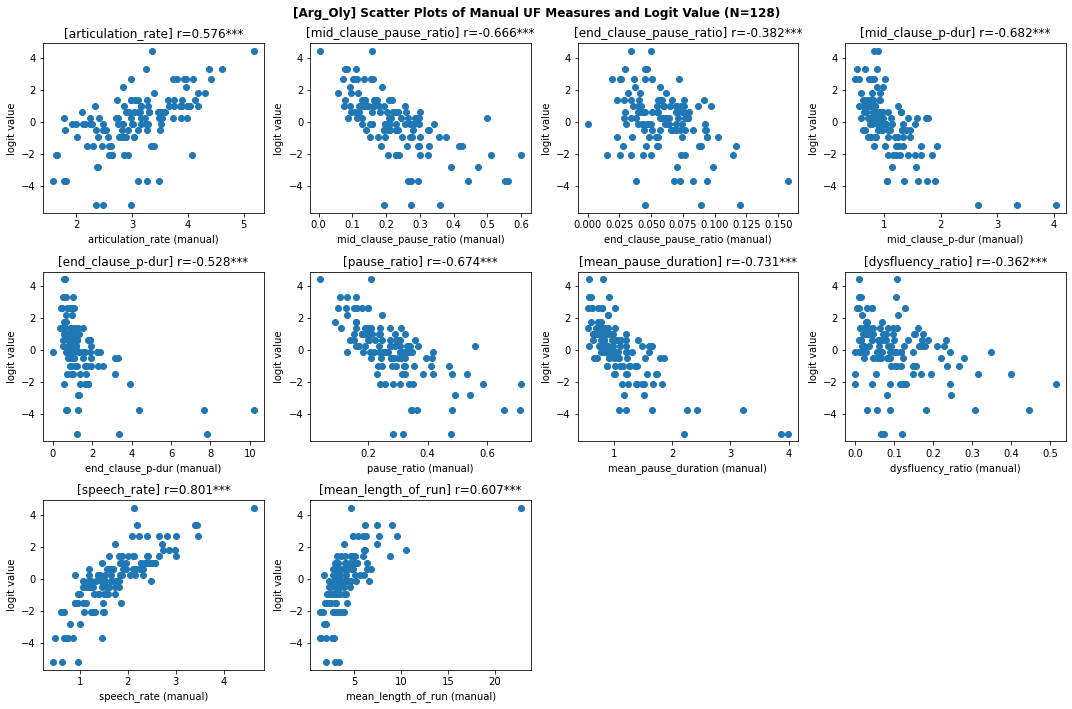

,r,p,sig
UF measures,,,
articulation_rate,0.576119,1.117537e-12,***
mid_clause_pause_ratio,-0.666073,9.549719e-18,***
end_clause_pause_ratio,-0.381752,8.738314e-06,***
mid_clause_p-dur,-0.681527,8.442876e-19,***
end_clause_p-dur,-0.528259,1.470380e-10,***
pause_ratio,-0.673848,2.870404e-18,***
mean_pause_duration,-0.731070,1.161674e-22,***
dysfluency_ratio,-0.361508,2.758112e-05,***
speech_rate,0.801305,6.807529e-30,***


In [7]:
task = "Arg_Oly"
manual = True
task_facet = False
X, Y = load_dataset(task, manual, task_facet)
correlation_analysis(task, X, Y, manual)

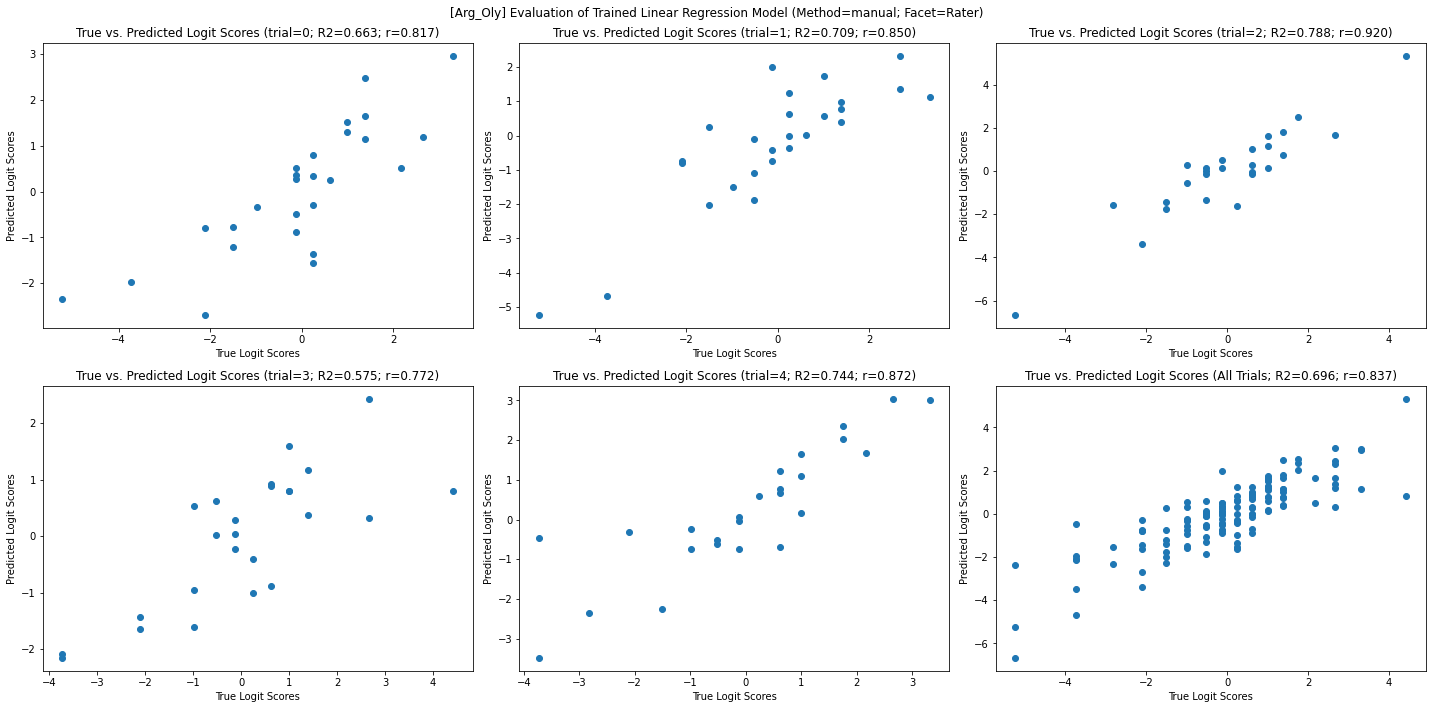

,task,method,facet,score,R2_lower,R2,R2_upper,r,articulation_rate_relimp_raw,articulation_rate_relimp_norm,...,mean_pause_duration_coef,dysfluency_ratio_relimp_raw,dysfluency_ratio_relimp_norm,dysfluency_ratio_coef,speech_rate_relimp_raw,speech_rate_relimp_norm,speech_rate_coef,mean_length_of_run_relimp_raw,mean_length_of_run_relimp_norm,mean_length_of_run_coef
name,,,,,,,,,,,,,,,,,,,,,
0 trial,Arg_Oly,manual,Rater,0.765375,0.545007,0.662748,0.780489,0.817080,0.095419,11.321626,...,-0.202067,0.035904,4.260059,-0.900166,0.032945,3.909009,1.779387,0.255348,30.297582,-0.035809
1 trial,Arg_Oly,manual,Rater,0.749605,0.603526,0.708693,0.813860,0.850426,0.098296,11.535978,...,-0.760176,0.040241,4.722663,-0.914623,0.033462,3.927026,1.482920,0.260377,30.557725,-0.019697
2 trial,Arg_Oly,manual,Rater,0.726763,0.706829,0.787649,0.868470,0.919893,0.342922,25.754007,...,-1.268724,0.070754,5.313772,-0.363413,0.035284,2.649856,0.735342,0.246131,18.484875,0.102501
3 trial,Arg_Oly,manual,Rater,0.776214,0.438533,0.575055,0.711578,0.771854,0.099468,11.834527,...,0.255583,0.036678,4.363903,-0.500937,0.029502,3.510088,1.615301,0.238801,28.412048,0.021873
4 trial,Arg_Oly,manual,Rater,0.745432,0.650428,0.743983,0.837538,0.872465,8.195690,4.184864,...,-1.044775,1.169570,0.597203,-1.143247,15.117040,7.719028,1.285608,17.108738,8.736025,-0.009067
Average,Arg_Oly,manual,Rater,NaN,0.588865,0.695626,0.802387,0.846344,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Concat,Arg_Oly,manual,Rater,NaN,0.615264,0.696235,0.777206,0.837002,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
results, train_indices_list, test_indices_list = train(X, Y)
df_eval = evaluate(task, results, manual, task_facet)
df_eval_list.append(df_eval)
df_eval

**Automatic Measures (Facet = Rater)**

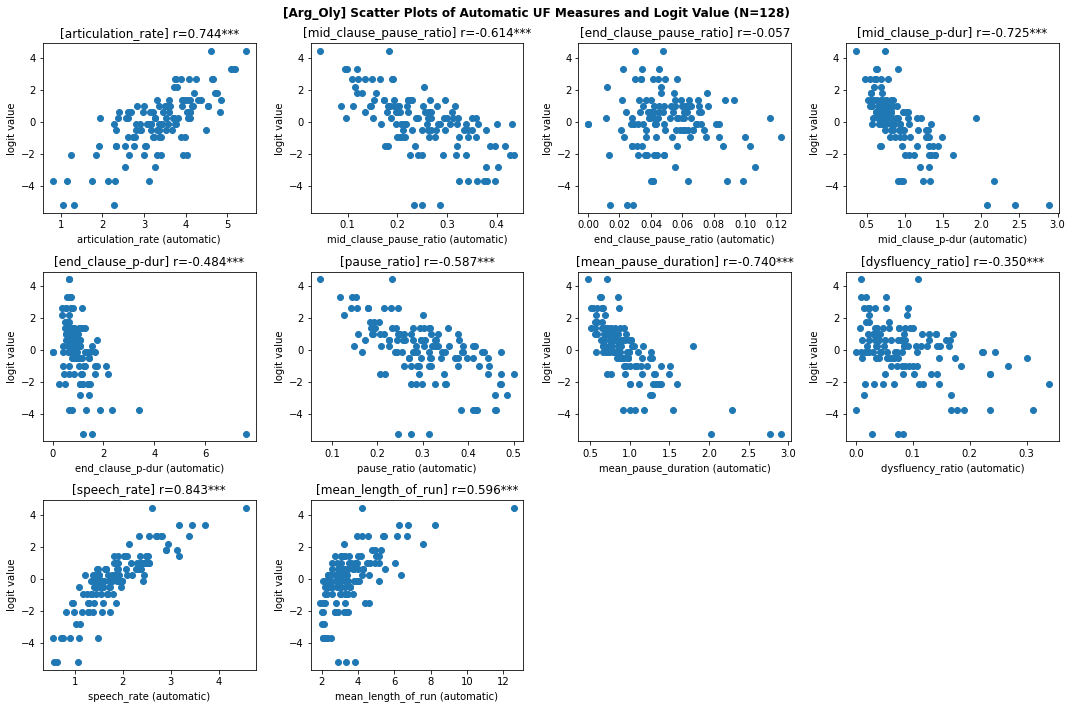

,r,p,sig
UF measures,,,
articulation_rate,0.743977,8.227291e-24,***
mid_clause_pause_ratio,-0.614126,1.268653e-14,***
end_clause_pause_ratio,-0.057377,5.200255e-01,
mid_clause_p-dur,-0.724751,4.019848e-22,***
end_clause_p-dur,-0.483885,7.192880e-09,***
pause_ratio,-0.586838,3.351903e-13,***
mean_pause_duration,-0.740007,1.888650e-23,***
dysfluency_ratio,-0.349771,5.188150e-05,***
speech_rate,0.842626,1.130142e-35,***


In [9]:
task = "Arg_Oly"
manual = False
task_facet = False
X, Y = load_dataset(task, manual, task_facet)
correlation_analysis(task, X, Y, manual)

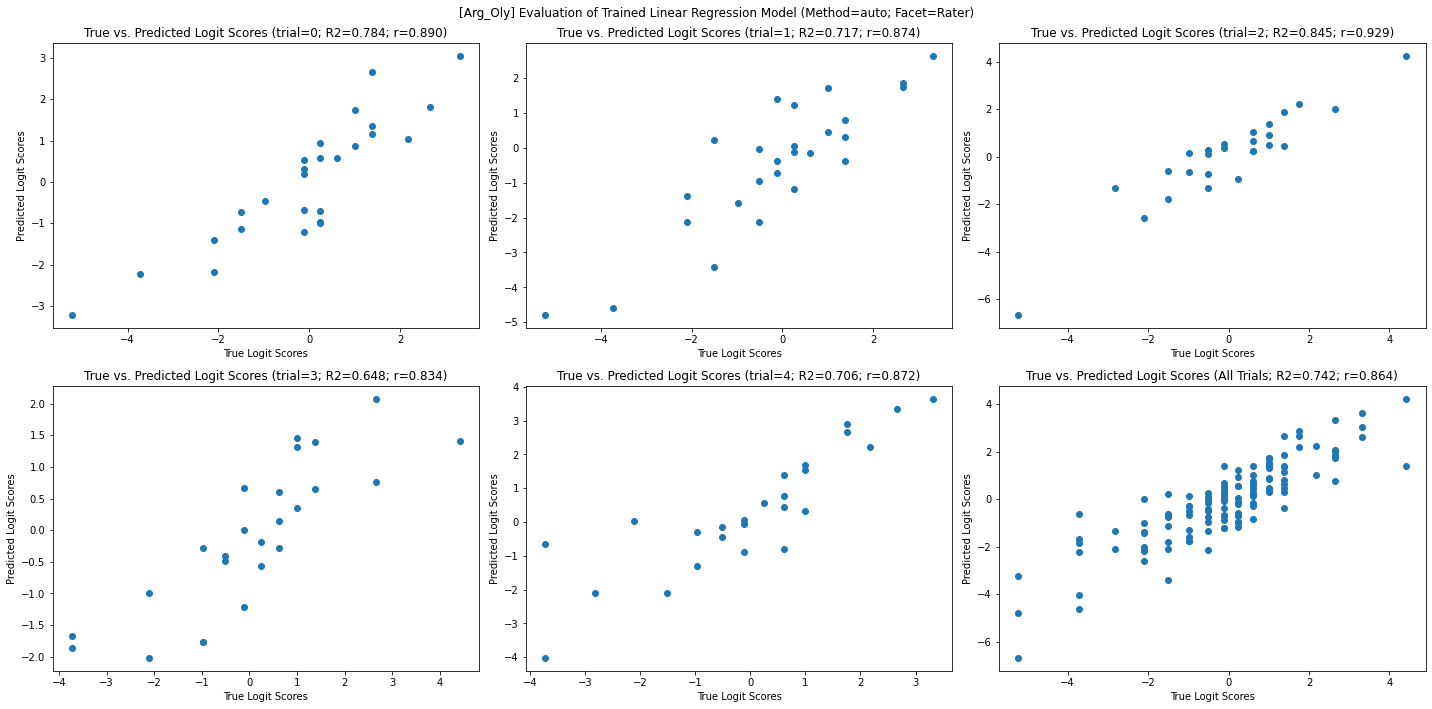

,task,method,facet,score,R2_lower,R2,R2_upper,r,articulation_rate_relimp_raw,articulation_rate_relimp_norm,...,mean_pause_duration_coef,dysfluency_ratio_relimp_raw,dysfluency_ratio_relimp_norm,dysfluency_ratio_coef,speech_rate_relimp_raw,speech_rate_relimp_norm,speech_rate_coef,mean_length_of_run_relimp_raw,mean_length_of_run_relimp_norm,mean_length_of_run_coef
name,,,,,,,,,,,,,,,,,,,,,
0 trial,Arg_Oly,auto,Rater,0.792829,0.702169,0.784141,0.866113,0.890119,0.218211,8.430300,...,-6.256747,0.050461,1.949486,-1.706916,0.081338,3.142401,1.072851,0.399217,15.423217,-0.028288
1 trial,Arg_Oly,auto,Rater,0.802016,0.613810,0.716671,0.819532,0.874205,0.993748,5.281664,...,-10.078322,0.070868,0.376655,-1.926061,0.732431,3.892789,0.593771,1.947073,10.348482,0.038431
2 trial,Arg_Oly,auto,Rater,0.774170,0.783950,0.845039,0.906128,0.928793,0.077598,8.367655,...,-11.013406,0.025529,2.752859,-1.847755,0.035311,3.807767,-0.069633,0.167701,18.083816,0.195181
3 trial,Arg_Oly,auto,Rater,0.821636,0.528514,0.648448,0.768383,0.833871,0.088616,9.869984,...,-8.757458,0.030101,3.352691,-1.951780,0.029401,3.274658,0.584439,0.190016,21.163944,0.177616
4 trial,Arg_Oly,auto,Rater,0.808845,0.601374,0.706024,0.810674,0.872457,0.711082,3.610610,...,-10.060071,0.030215,0.153419,-1.233429,0.582575,2.958095,0.741067,1.922594,9.762212,0.043437
Average,Arg_Oly,auto,Rater,NaN,0.645963,0.740065,0.834166,0.879889,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Concat,Arg_Oly,auto,Rater,NaN,0.670511,0.741599,0.812686,0.863533,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
results, _, _ = train(X, Y, train_indices_list, test_indices_list)
df_eval = evaluate(task, results, manual, task_facet)
df_eval_list.append(df_eval)
df_eval

**Manual Measures (Facet = Rater, Task)**

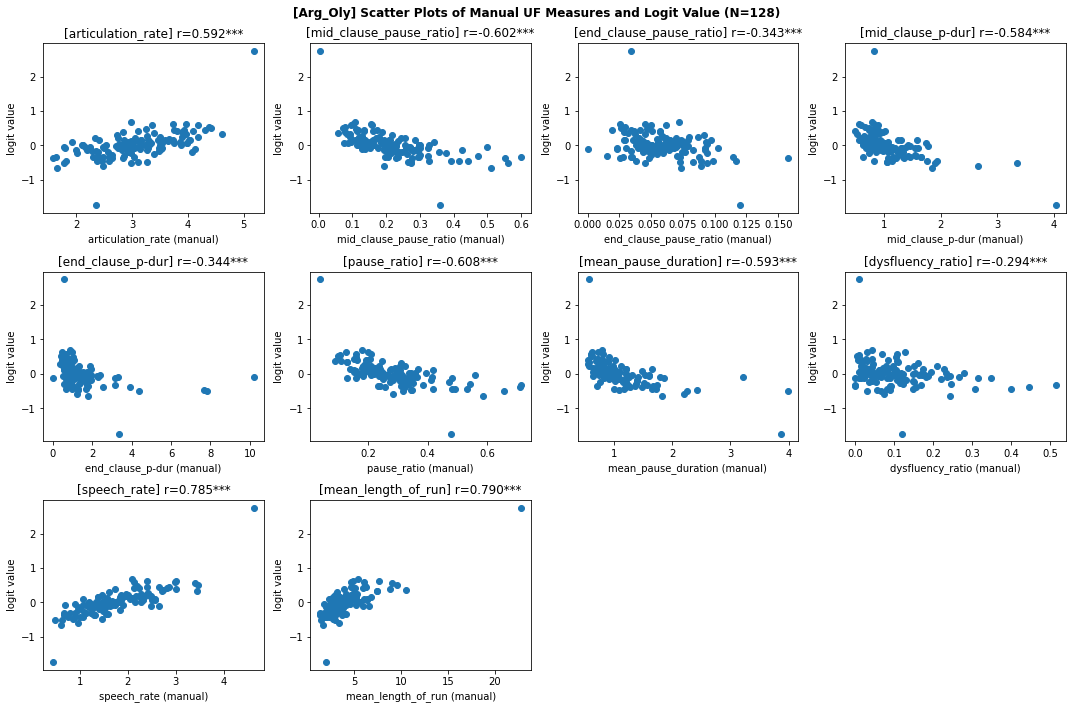

,r,p,sig
UF measures,,,
articulation_rate,0.592360,1.771158e-13,***
mid_clause_pause_ratio,-0.601817,5.773985e-14,***
end_clause_pause_ratio,-0.342525,7.570007e-05,***
mid_clause_p-dur,-0.584087,4.584950e-13,***
end_clause_p-dur,-0.344329,6.896365e-05,***
pause_ratio,-0.608363,2.600262e-14,***
mean_pause_duration,-0.592776,1.687244e-13,***
dysfluency_ratio,-0.293706,7.658844e-04,***
speech_rate,0.784589,6.265241e-28,***


In [11]:
task = "Arg_Oly"
manual = True
task_facet = True
X, Y = load_dataset(task, manual, task_facet)
correlation_analysis(task, X, Y, manual)

/tmp/ipykernel_992402/1271605277.py:5: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(bunshi/bunbo)


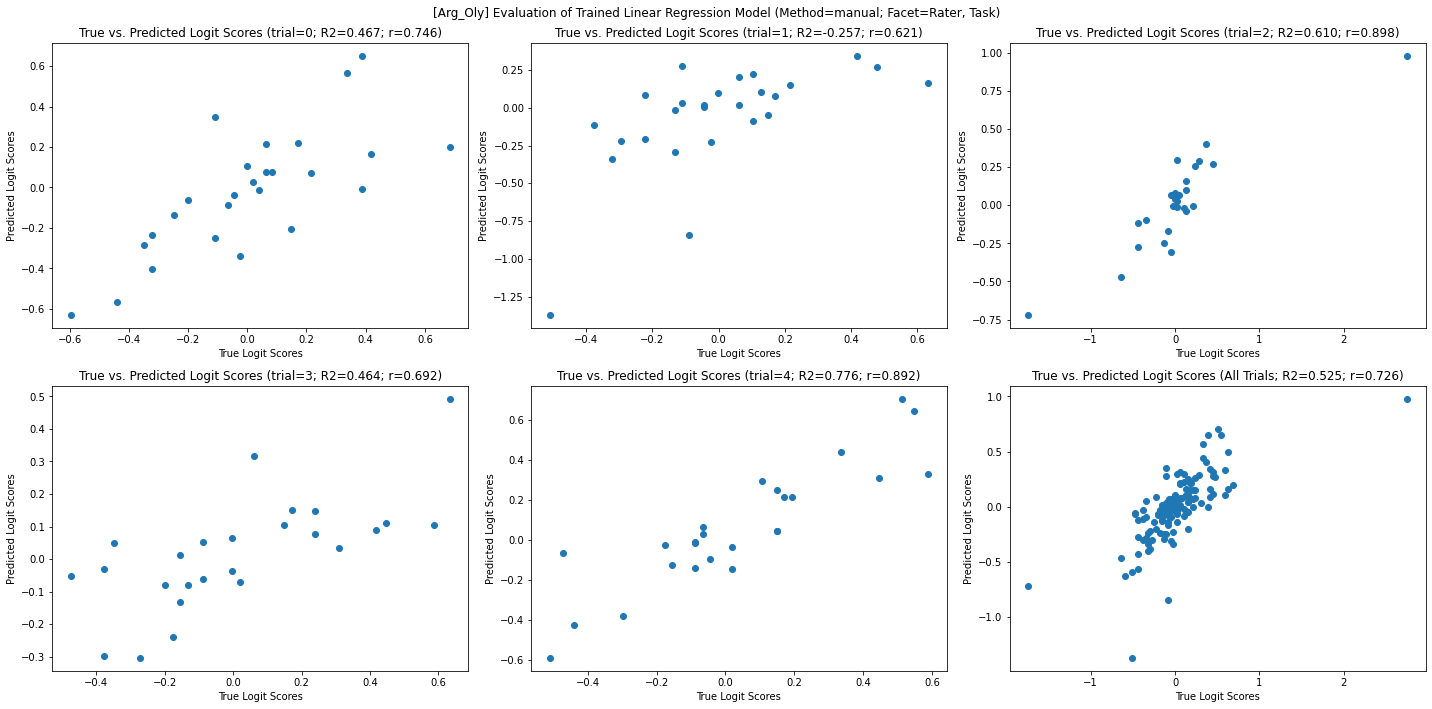

,task,method,facet,score,R2_lower,R2,R2_upper,r,articulation_rate_relimp_raw,articulation_rate_relimp_norm,...,mean_pause_duration_coef,dysfluency_ratio_relimp_raw,dysfluency_ratio_relimp_norm,dysfluency_ratio_coef,speech_rate_relimp_raw,speech_rate_relimp_norm,speech_rate_coef,mean_length_of_run_relimp_raw,mean_length_of_run_relimp_norm,mean_length_of_run_coef
name,,,,,,,,,,,,,,,,,,,,,
0 trial,Arg_Oly,manual,"Rater, Task",0.817786,0.310268,0.466529,0.622790,0.746414,0.248009,27.676053,...,-0.690965,0.035458,3.956868,0.060820,0.032319,3.606570,-0.115319,0.197886,22.082737,0.130683
1 trial,Arg_Oly,manual,"Rater, Task",0.837512,NaN,-0.257067,NaN,0.621109,0.245832,26.773319,...,-0.573868,0.042486,4.627102,-0.305675,0.031144,3.391886,-0.341814,0.210142,22.886294,0.157970
2 trial,Arg_Oly,manual,"Rater, Task",0.645498,0.479731,0.610291,0.740851,0.898165,0.104493,9.941025,...,-0.148767,0.035844,3.410043,0.339532,0.044281,4.212715,0.270897,0.233947,22.256793,0.007568
3 trial,Arg_Oly,manual,"Rater, Task",0.820177,0.309374,0.464050,0.618726,0.692377,0.247731,27.241052,...,-0.690470,0.037297,4.101208,0.114852,0.029191,3.209957,-0.296197,0.194682,21.407690,0.153667
4 trial,Arg_Oly,manual,"Rater, Task",0.787111,0.692270,0.775900,0.859530,0.892360,0.279010,31.102703,...,-0.763637,0.040536,4.518726,0.107621,0.023157,2.581391,-0.295736,0.209301,23.331831,0.148337
Average,Arg_Oly,manual,"Rater, Task",NaN,NaN,0.411940,NaN,0.770085,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Concat,Arg_Oly,manual,"Rater, Task",NaN,0.414547,0.524552,0.634556,0.725603,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
results, _, _ = train(X, Y, train_indices_list, test_indices_list)
df_eval = evaluate(task, results, manual, task_facet)
df_eval_list.append(df_eval)
df_eval

**Automatic Measures (Facet = Rater, Task)**

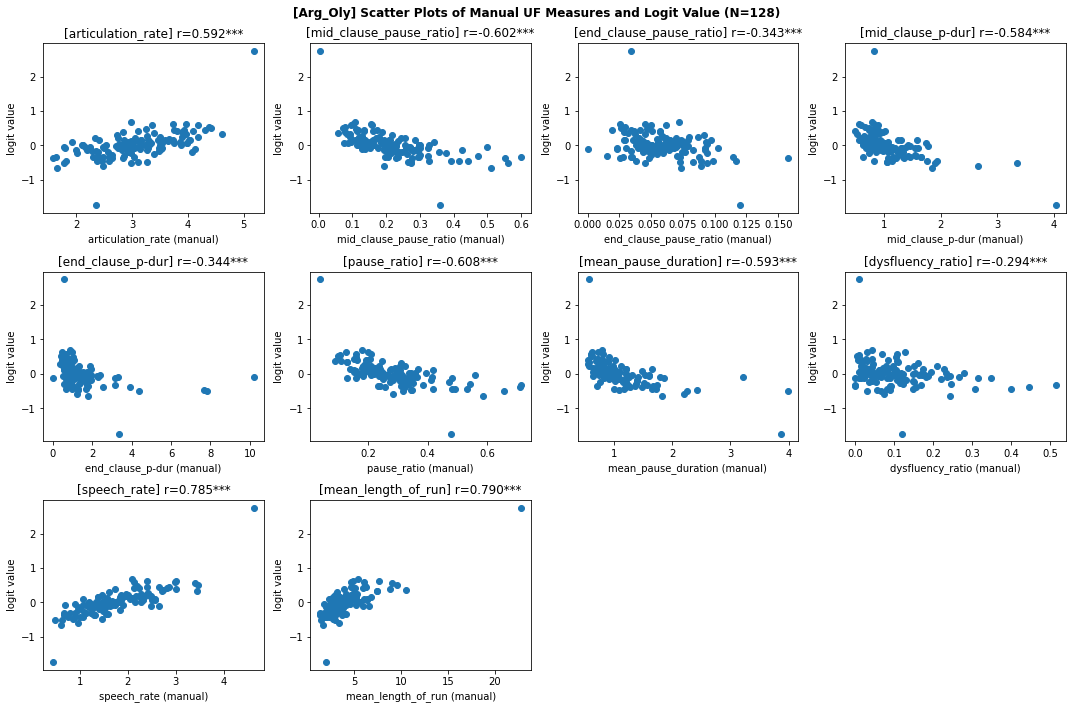

,r,p,sig
UF measures,,,
articulation_rate,0.592360,1.771158e-13,***
mid_clause_pause_ratio,-0.601817,5.773985e-14,***
end_clause_pause_ratio,-0.342525,7.570007e-05,***
mid_clause_p-dur,-0.584087,4.584950e-13,***
end_clause_p-dur,-0.344329,6.896365e-05,***
pause_ratio,-0.608363,2.600262e-14,***
mean_pause_duration,-0.592776,1.687244e-13,***
dysfluency_ratio,-0.293706,7.658844e-04,***
speech_rate,0.784589,6.265241e-28,***


In [13]:
task = "Arg_Oly"
manual = True
task_facet = True
X, Y = load_dataset(task, manual, task_facet)
correlation_analysis(task, X, Y, manual)

/tmp/ipykernel_992402/1271605277.py:5: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(bunshi/bunbo)


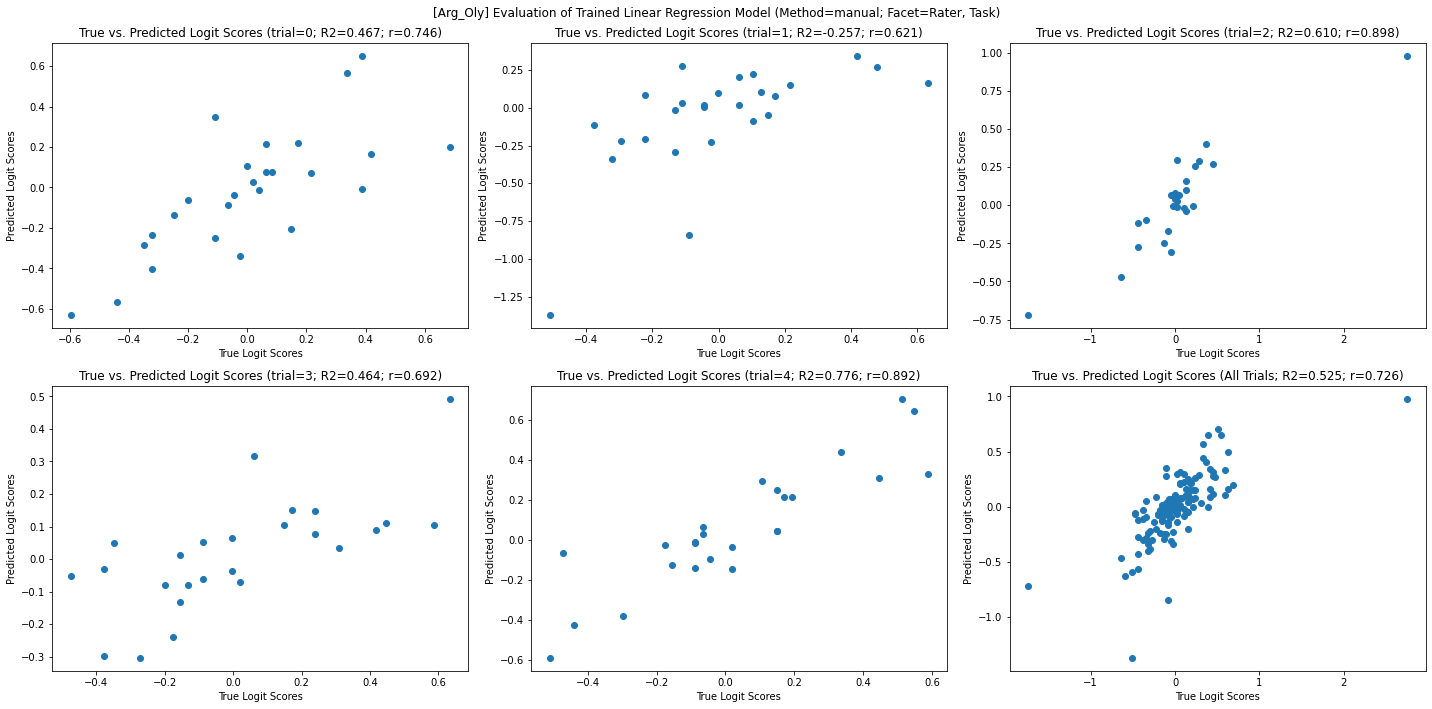

,task,method,facet,score,R2_lower,R2,R2_upper,r,articulation_rate_relimp_raw,articulation_rate_relimp_norm,...,mean_pause_duration_coef,dysfluency_ratio_relimp_raw,dysfluency_ratio_relimp_norm,dysfluency_ratio_coef,speech_rate_relimp_raw,speech_rate_relimp_norm,speech_rate_coef,mean_length_of_run_relimp_raw,mean_length_of_run_relimp_norm,mean_length_of_run_coef
name,,,,,,,,,,,,,,,,,,,,,
0 trial,Arg_Oly,manual,"Rater, Task",0.817786,0.310268,0.466529,0.622790,0.746414,0.248009,27.676053,...,-0.690965,0.035458,3.956868,0.060820,0.032319,3.606570,-0.115319,0.197886,22.082737,0.130683
1 trial,Arg_Oly,manual,"Rater, Task",0.837512,NaN,-0.257067,NaN,0.621109,0.245832,26.773319,...,-0.573868,0.042486,4.627102,-0.305675,0.031144,3.391886,-0.341814,0.210142,22.886294,0.157970
2 trial,Arg_Oly,manual,"Rater, Task",0.645498,0.479731,0.610291,0.740851,0.898165,0.104493,9.941025,...,-0.148767,0.035844,3.410043,0.339532,0.044281,4.212715,0.270897,0.233947,22.256793,0.007568
3 trial,Arg_Oly,manual,"Rater, Task",0.820177,0.309374,0.464050,0.618726,0.692377,0.247731,27.241052,...,-0.690470,0.037297,4.101208,0.114852,0.029191,3.209957,-0.296197,0.194682,21.407690,0.153667
4 trial,Arg_Oly,manual,"Rater, Task",0.787111,0.692270,0.775900,0.859530,0.892360,0.279010,31.102703,...,-0.763637,0.040536,4.518726,0.107621,0.023157,2.581391,-0.295736,0.209301,23.331831,0.148337
Average,Arg_Oly,manual,"Rater, Task",NaN,NaN,0.411940,NaN,0.770085,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Concat,Arg_Oly,manual,"Rater, Task",NaN,0.414547,0.524552,0.634556,0.725603,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
results, _, _ = train(X, Y, train_indices_list, test_indices_list)
df_eval = evaluate(task, results, manual, task_facet)
df_eval_list.append(df_eval)
df_eval

### 3.2. Cartoon

**Manual Measures (Facet = Rater)**

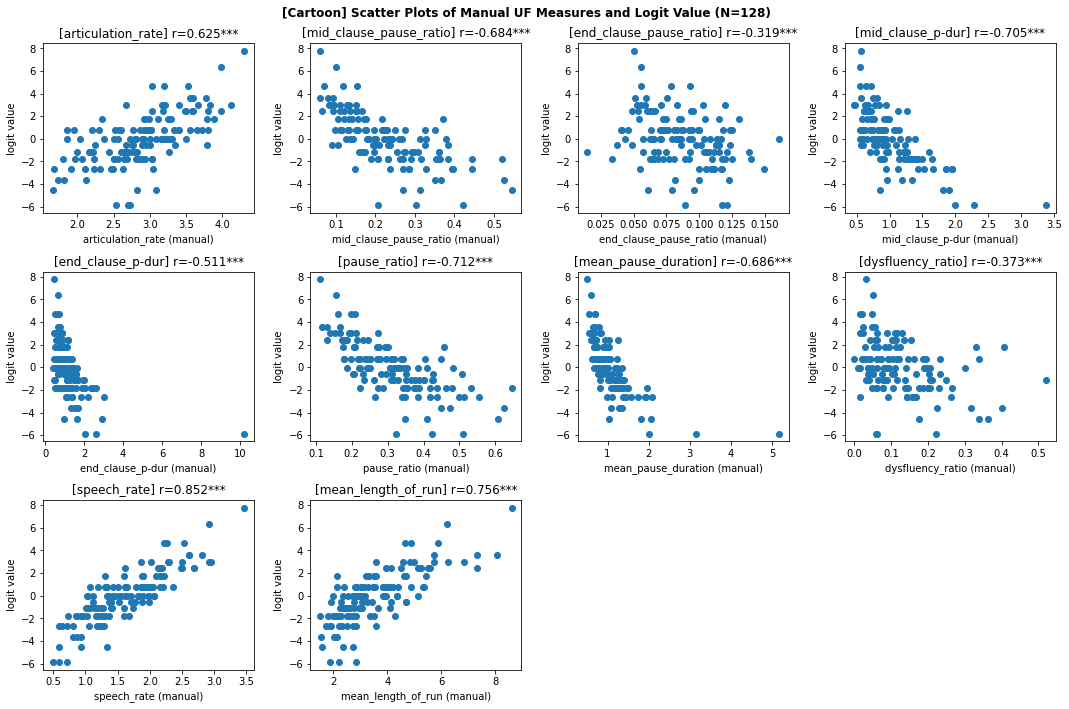

,r,p,sig
UF measures,,,
articulation_rate,0.625416,2.978254e-15,***
mid_clause_pause_ratio,-0.684250,5.422268e-19,***
end_clause_pause_ratio,-0.319443,2.374664e-04,***
mid_clause_p-dur,-0.705371,1.472384e-20,***
end_clause_p-dur,-0.511329,6.930026e-10,***
pause_ratio,-0.711815,4.596044e-21,***
mean_pause_duration,-0.685528,4.396623e-19,***
dysfluency_ratio,-0.372952,1.453907e-05,***
speech_rate,0.852206,2.963526e-37,***


In [15]:
task = "Cartoon"
manual = True
task_facet = False
X, Y = load_dataset(task, manual, task_facet)
correlation_analysis(task, X, Y, manual)

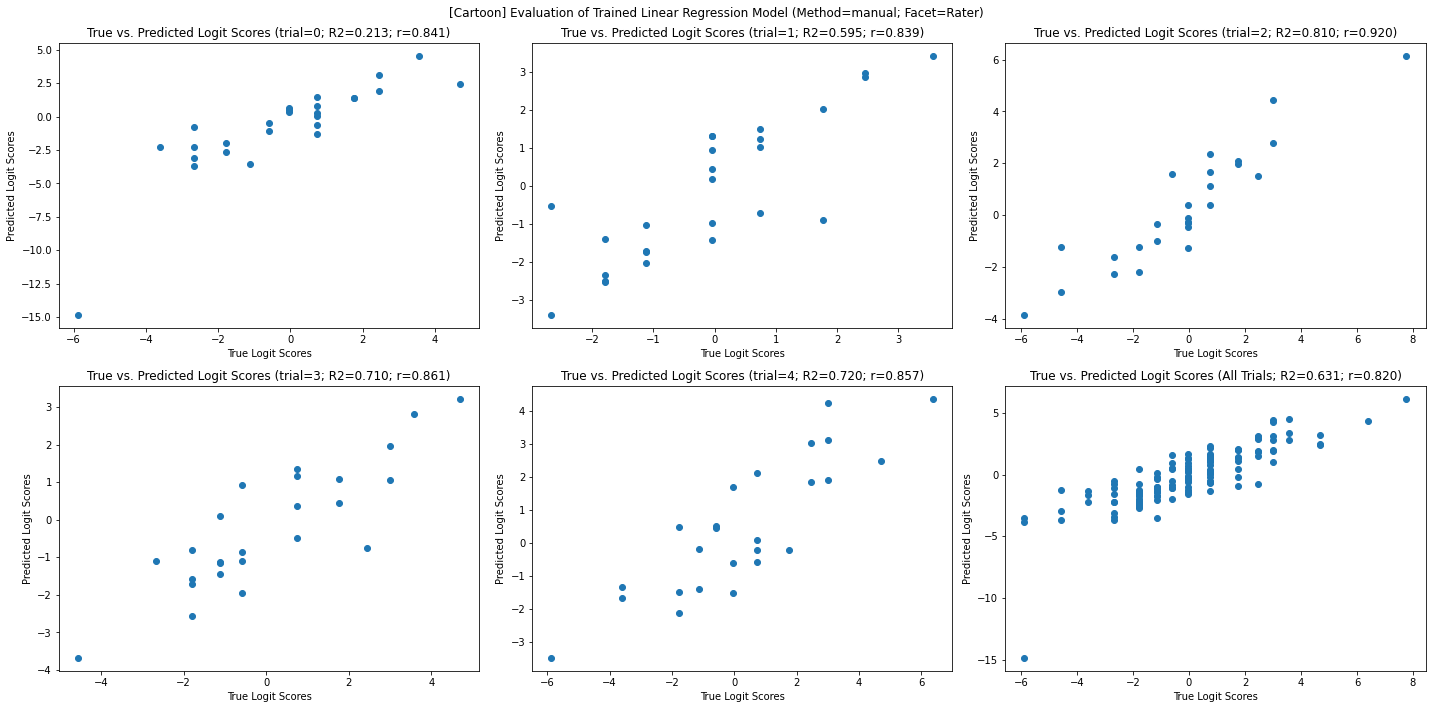

,task,method,facet,score,R2_lower,R2,R2_upper,r,articulation_rate_relimp_raw,articulation_rate_relimp_norm,...,mean_pause_duration_coef,dysfluency_ratio_relimp_raw,dysfluency_ratio_relimp_norm,dysfluency_ratio_coef,speech_rate_relimp_raw,speech_rate_relimp_norm,speech_rate_coef,mean_length_of_run_relimp_raw,mean_length_of_run_relimp_norm,mean_length_of_run_coef
name,,,,,,,,,,,,,,,,,,,,,
0 trial,Cartoon,manual,Rater,0.789653,0.057560,0.213388,0.369216,0.840770,1.421509e+23,5.009486,...,-5.955772,5.482929e+22,1.932218,-1.733846,1.758704e+23,6.197780,3.123265,2.864969e+23,10.096327,0.318064
1 trial,Cartoon,manual,Rater,0.796483,0.461276,0.595203,0.729131,0.839314,9.931643e+00,5.738207,...,-1.614902,1.482171e+00,0.856354,-1.038829,1.071925e+01,6.193265,4.963786,1.787124e+01,10.325468,-0.162054
2 trial,Cartoon,manual,Rater,0.763734,0.736628,0.809971,0.883313,0.920491,1.079866e-01,11.571710,...,-1.197154,2.603721e-02,2.790114,1.318230,5.843778e-02,6.262119,5.288308,1.701934e-01,18.237716,-0.249466
3 trial,Cartoon,manual,Rater,0.791904,0.606302,0.709865,0.813428,0.860573,8.238121e-01,5.501928,...,-0.765745,1.445230e-01,0.965214,-0.817858,9.313686e-01,6.220258,5.431362,1.579974e+00,10.552050,-0.223732
4 trial,Cartoon,manual,Rater,0.796801,0.618900,0.719656,0.820412,0.856608,1.191795e-01,12.704746,...,-1.733979,2.896551e-02,3.087775,0.263323,4.639083e-02,4.945345,5.106582,1.766928e-01,18.835766,-0.137851
Average,Cartoon,manual,Rater,NaN,0.496133,0.609617,0.723100,0.863551,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Concat,Cartoon,manual,Rater,NaN,0.537342,0.630984,0.724625,0.819804,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
results, _, _ = train(X, Y, train_indices_list, test_indices_list)
df_eval = evaluate(task, results, manual, task_facet)
df_eval_list.append(df_eval)
df_eval

**Automatic Measures (Facet = Rater)**

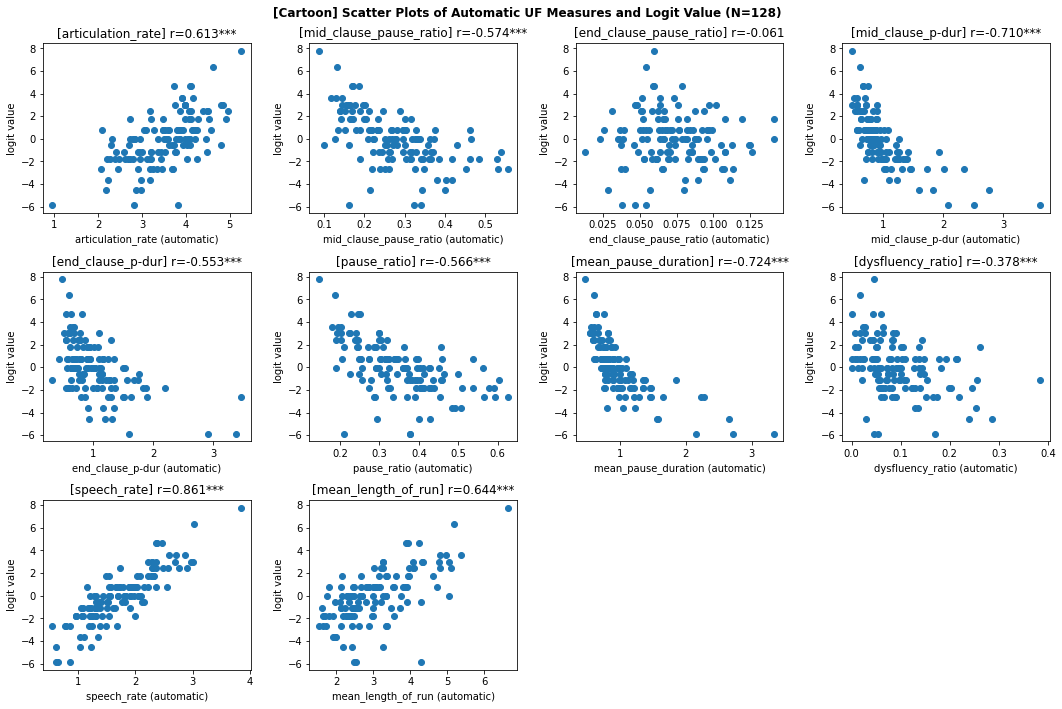

,r,p,sig
UF measures,,,
articulation_rate,0.612759,1.505959e-14,***
mid_clause_pause_ratio,-0.573952,1.418196e-12,***
end_clause_pause_ratio,-0.060576,4.969825e-01,
mid_clause_p-dur,-0.709880,6.541018e-21,***
end_clause_p-dur,-0.552535,1.363167e-11,***
pause_ratio,-0.565884,3.390297e-12,***
mean_pause_duration,-0.723555,5.064672e-22,***
dysfluency_ratio,-0.377565,1.115420e-05,***
speech_rate,0.860955,8.449894e-39,***


In [17]:
task = "Cartoon"
manual = False
task_facet = False
X, Y = load_dataset(task, manual, task_facet)
correlation_analysis(task, X, Y, manual)

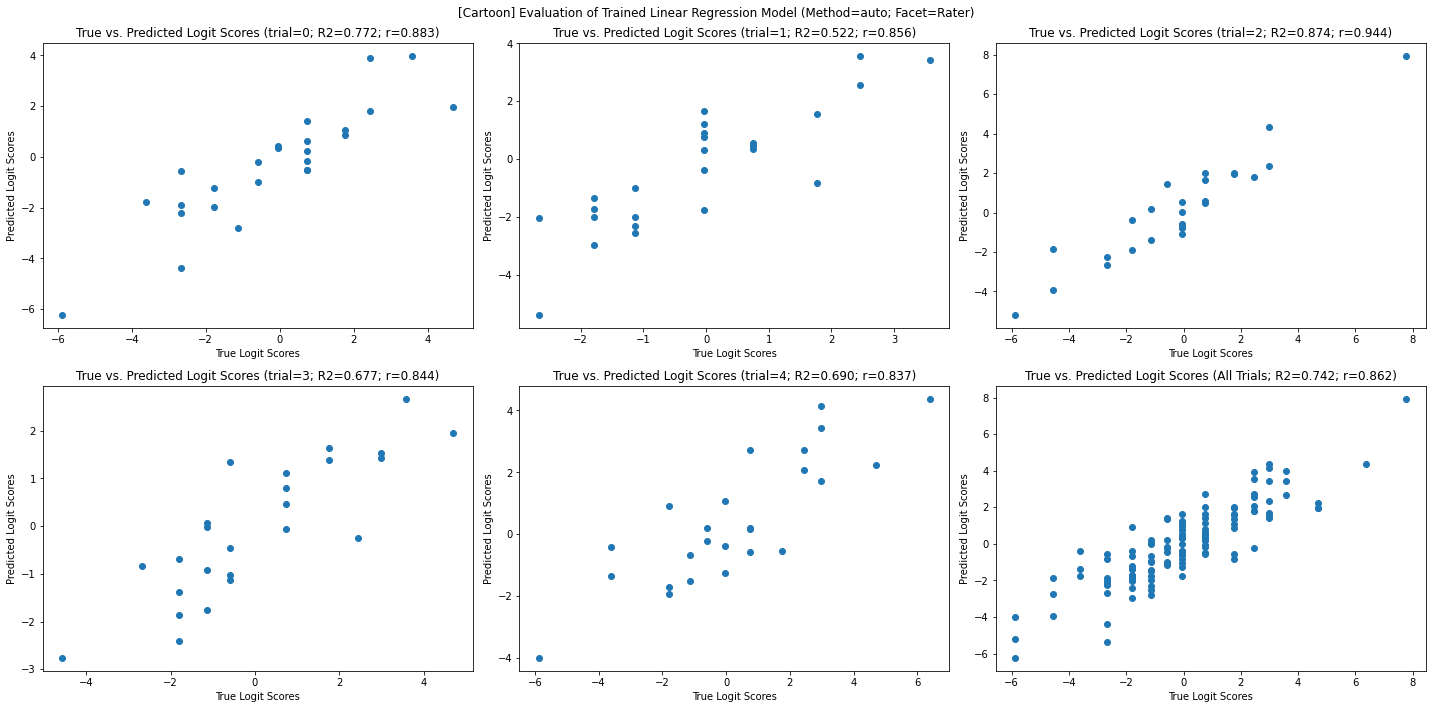

,task,method,facet,score,R2_lower,R2,R2_upper,r,articulation_rate_relimp_raw,articulation_rate_relimp_norm,...,mean_pause_duration_coef,dysfluency_ratio_relimp_raw,dysfluency_ratio_relimp_norm,dysfluency_ratio_coef,speech_rate_relimp_raw,speech_rate_relimp_norm,speech_rate_coef,mean_length_of_run_relimp_raw,mean_length_of_run_relimp_norm,mean_length_of_run_coef
name,,,,,,,,,,,,,,,,,,,,,
0 trial,Cartoon,auto,Rater,0.790600,0.686264,0.772132,0.857999,0.882717,1.092416e-01,11.455795,...,-0.091383,3.227455e-02,3.384522,-0.361381,4.293708e-02,4.502665,3.598979,1.767851e-01,18.538849,0.488744
1 trial,Cartoon,auto,Rater,0.803665,0.373958,0.522053,0.670147,0.856461,4.744185e+26,3.157123,...,2.399404,3.415001e+25,0.227259,-0.296056,4.101626e+26,2.729518,2.809975,1.455396e+27,9.685257,0.464563
2 trial,Cartoon,auto,Rater,0.750644,0.823797,0.874228,0.924659,0.943564,9.092874e-02,9.523766,...,-0.135299,2.669380e-02,2.795876,3.373137,4.465069e-02,4.676659,3.820395,1.669864e-01,17.489958,0.254330
3 trial,Cartoon,auto,Rater,0.807022,0.564525,0.677094,0.789663,0.844493,9.325117e-02,9.865043,...,2.853092,2.726003e-02,2.883839,-0.096652,3.844020e-02,4.066590,3.633743,1.635161e-01,17.298366,0.320202
4 trial,Cartoon,auto,Rater,0.820675,0.581146,0.690189,0.799232,0.836721,1.716220e+00,3.072725,...,-0.214581,1.373147e-01,0.245849,2.624505,1.265365e+00,2.265512,3.282049,5.411860e+00,9.689409,0.541187
Average,Cartoon,auto,Rater,NaN,0.605938,0.707139,0.808340,0.872791,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Concat,Cartoon,auto,Rater,NaN,0.670492,0.741583,0.812674,0.862331,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
results, _, _ = train(X, Y, train_indices_list, test_indices_list)
df_eval = evaluate(task, results, manual, task_facet)
df_eval_list.append(df_eval)
df_eval

**Manual Measures (Facet = Rater, Task)**

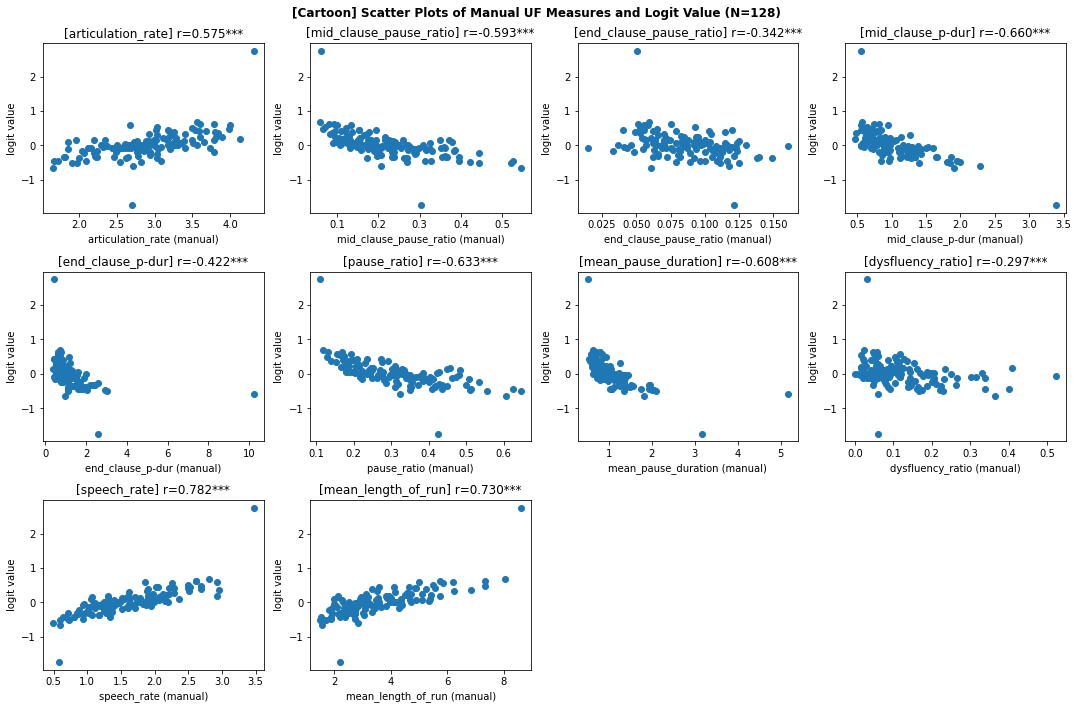

,r,p,sig
UF measures,,,
articulation_rate,0.574946,1.271589e-12,***
mid_clause_pause_ratio,-0.593309,1.585478e-13,***
end_clause_pause_ratio,-0.342110,7.733438e-05,***
mid_clause_p-dur,-0.659658,2.506965e-17,***
end_clause_p-dur,-0.421954,7.023886e-07,***
pause_ratio,-0.632659,1.139161e-15,***
mean_pause_duration,-0.607680,2.828132e-14,***
dysfluency_ratio,-0.297051,6.617059e-04,***
speech_rate,0.781614,1.343337e-27,***


In [19]:
task = "Cartoon"
manual = True
task_facet = True
X, Y = load_dataset(task, manual, task_facet)
correlation_analysis(task, X, Y, manual)

/tmp/ipykernel_992402/1271605277.py:5: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(bunshi/bunbo)


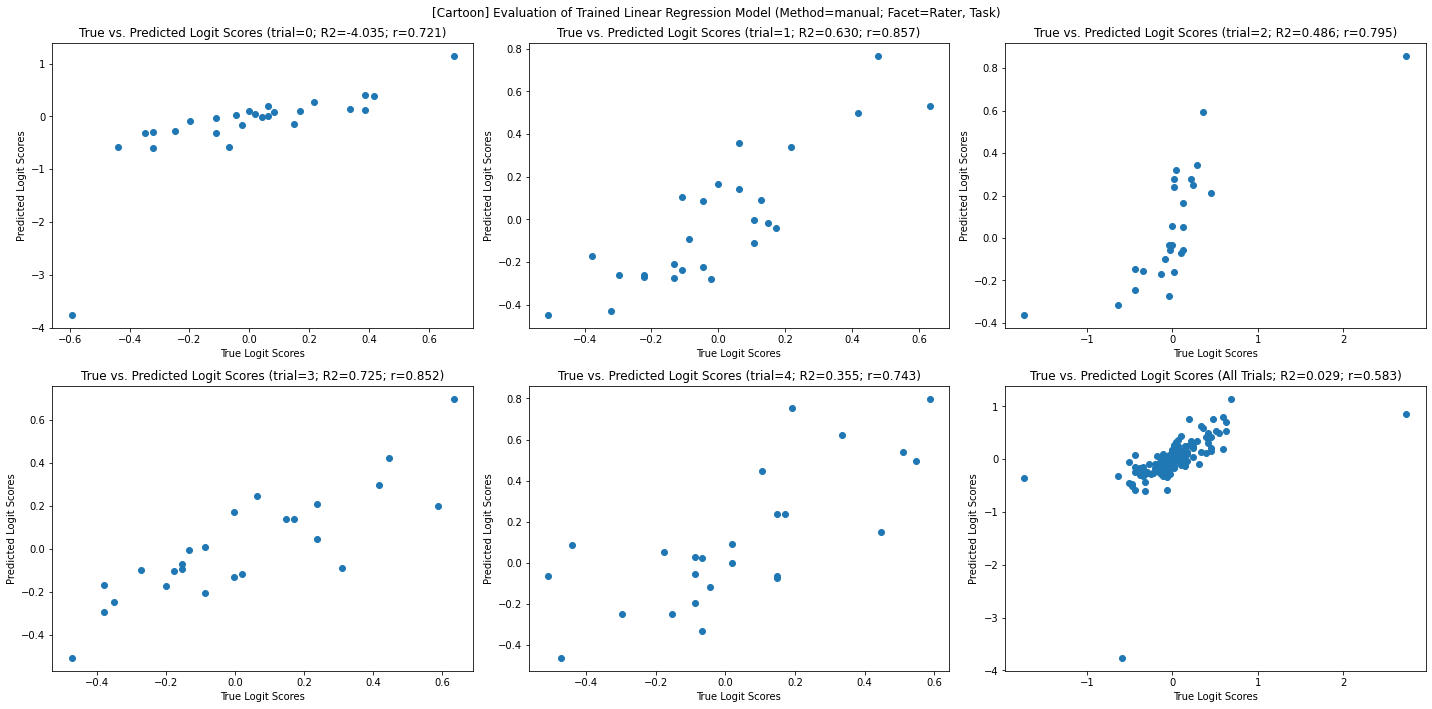

,task,method,facet,score,R2_lower,R2,R2_upper,r,articulation_rate_relimp_raw,articulation_rate_relimp_norm,...,mean_pause_duration_coef,dysfluency_ratio_relimp_raw,dysfluency_ratio_relimp_norm,dysfluency_ratio_coef,speech_rate_relimp_raw,speech_rate_relimp_norm,speech_rate_coef,mean_length_of_run_relimp_raw,mean_length_of_run_relimp_norm,mean_length_of_run_coef
name,,,,,,,,,,,,,,,,,,,,,
0 trial,Cartoon,manual,"Rater, Task",0.726237,NaN,-4.035413,NaN,0.720579,1.161946e+00,3.487907,...,-1.831501,6.602626e-01,1.981963,-0.279012,2.095000e+00,6.288730,-0.321056,3.344796e+00,10.040341,0.332983
1 trial,Cartoon,manual,"Rater, Task",0.673113,0.504508,0.630363,0.756218,0.857206,3.892099e+00,3.614066,...,-0.155857,9.603334e-01,0.891732,-0.044830,7.078887e+00,6.573205,0.274406,1.124663e+01,10.443225,0.180046
2 trial,Cartoon,manual,"Rater, Task",0.770666,0.332284,0.485957,0.639631,0.794532,1.275520e-01,13.674299,...,-0.047409,2.614669e-02,2.803073,0.362470,5.878869e-02,6.302481,0.576338,1.650258e-01,17.691698,0.008460
3 trial,Cartoon,manual,"Rater, Task",0.664422,0.625405,0.724696,0.823986,0.851813,2.198850e+25,3.286405,...,-0.081876,6.735082e+24,1.006627,-0.147574,3.948231e+25,5.901033,0.315790,7.226420e+25,10.800621,0.163639
4 trial,Cartoon,manual,"Rater, Task",0.694534,0.192057,0.354873,0.517690,0.742897,1.257393e-01,13.350196,...,-0.127638,2.790308e-02,2.962571,-0.027807,4.763196e-02,5.057256,0.465723,1.730701e-01,18.375478,0.174934
Average,Cartoon,manual,"Rater, Task",NaN,NaN,-0.367905,NaN,0.793405,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Concat,Cartoon,manual,"Rater, Task",NaN,-0.023854,0.028786,0.081427,0.583390,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
results, _, _ = train(X, Y, train_indices_list, test_indices_list)
df_eval = evaluate(task, results, manual, task_facet)
df_eval_list.append(df_eval)
df_eval

**Automatic Measures (Facet = Rater, Task)**

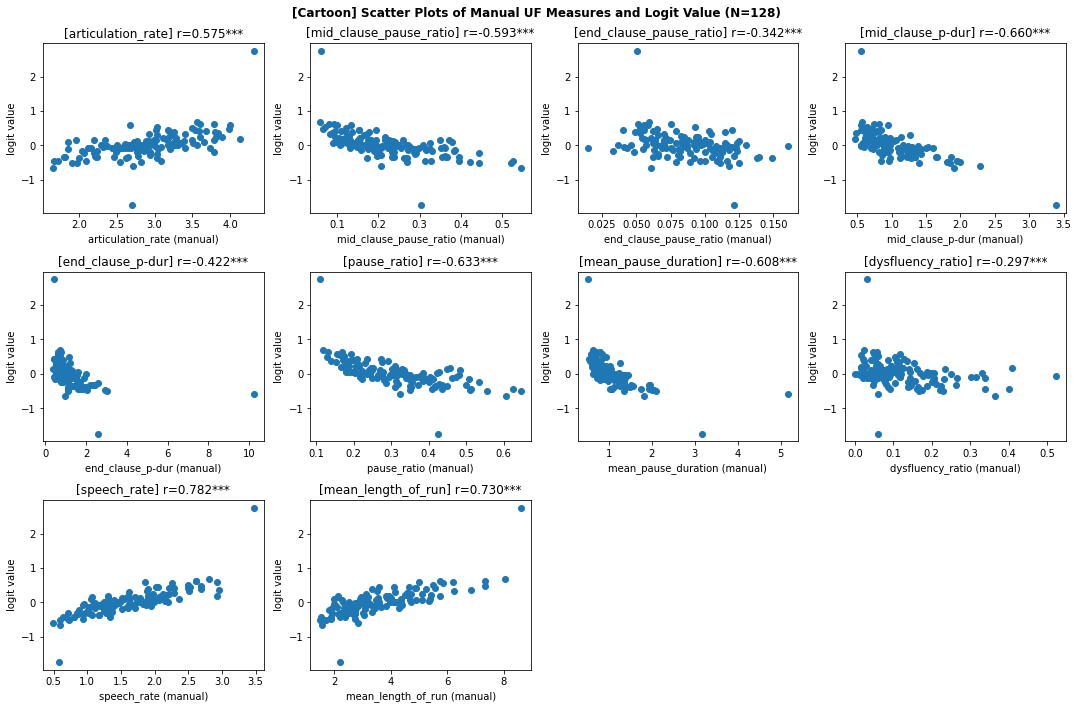

,r,p,sig
UF measures,,,
articulation_rate,0.574946,1.271589e-12,***
mid_clause_pause_ratio,-0.593309,1.585478e-13,***
end_clause_pause_ratio,-0.342110,7.733438e-05,***
mid_clause_p-dur,-0.659658,2.506965e-17,***
end_clause_p-dur,-0.421954,7.023886e-07,***
pause_ratio,-0.632659,1.139161e-15,***
mean_pause_duration,-0.607680,2.828132e-14,***
dysfluency_ratio,-0.297051,6.617059e-04,***
speech_rate,0.781614,1.343337e-27,***


In [21]:
task = "Cartoon"
manual = True
task_facet = True
X, Y = load_dataset(task, manual, task_facet)
correlation_analysis(task, X, Y, manual)

/tmp/ipykernel_992402/1271605277.py:5: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(bunshi/bunbo)


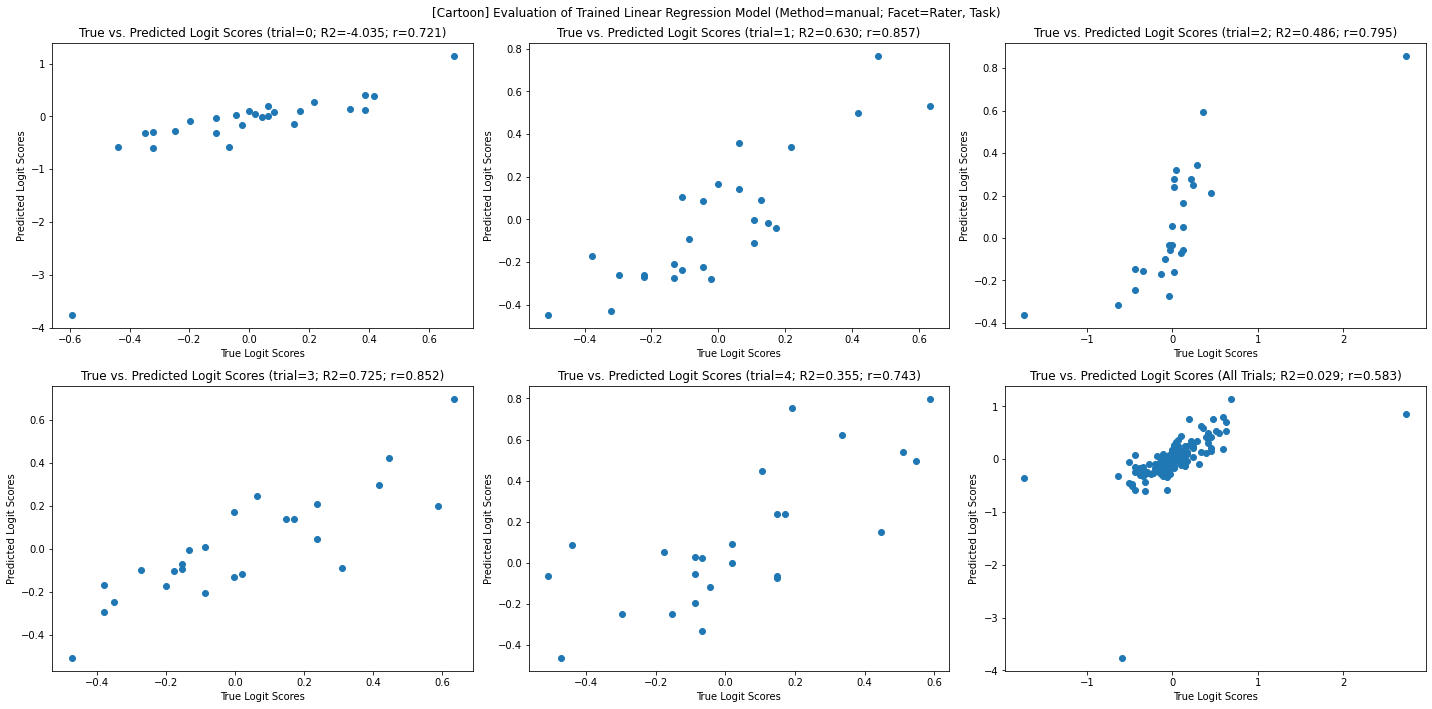

,task,method,facet,score,R2_lower,R2,R2_upper,r,articulation_rate_relimp_raw,articulation_rate_relimp_norm,...,mean_pause_duration_coef,dysfluency_ratio_relimp_raw,dysfluency_ratio_relimp_norm,dysfluency_ratio_coef,speech_rate_relimp_raw,speech_rate_relimp_norm,speech_rate_coef,mean_length_of_run_relimp_raw,mean_length_of_run_relimp_norm,mean_length_of_run_coef
name,,,,,,,,,,,,,,,,,,,,,
0 trial,Cartoon,manual,"Rater, Task",0.726237,NaN,-4.035413,NaN,0.720579,1.161946e+00,3.487907,...,-1.831501,6.602626e-01,1.981963,-0.279012,2.095000e+00,6.288730,-0.321056,3.344796e+00,10.040341,0.332983
1 trial,Cartoon,manual,"Rater, Task",0.673113,0.504508,0.630363,0.756218,0.857206,3.892099e+00,3.614066,...,-0.155857,9.603334e-01,0.891732,-0.044830,7.078887e+00,6.573205,0.274406,1.124663e+01,10.443225,0.180046
2 trial,Cartoon,manual,"Rater, Task",0.770666,0.332284,0.485957,0.639631,0.794532,1.275520e-01,13.674299,...,-0.047409,2.614669e-02,2.803073,0.362470,5.878869e-02,6.302481,0.576338,1.650258e-01,17.691698,0.008460
3 trial,Cartoon,manual,"Rater, Task",0.664422,0.625405,0.724696,0.823986,0.851813,2.198850e+25,3.286405,...,-0.081876,6.735082e+24,1.006627,-0.147574,3.948231e+25,5.901033,0.315790,7.226420e+25,10.800621,0.163639
4 trial,Cartoon,manual,"Rater, Task",0.694534,0.192057,0.354873,0.517690,0.742897,1.257393e-01,13.350196,...,-0.127638,2.790308e-02,2.962571,-0.027807,4.763196e-02,5.057256,0.465723,1.730701e-01,18.375478,0.174934
Average,Cartoon,manual,"Rater, Task",NaN,NaN,-0.367905,NaN,0.793405,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Concat,Cartoon,manual,"Rater, Task",NaN,-0.023854,0.028786,0.081427,0.583390,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
results, _, _ = train(X, Y, train_indices_list, test_indices_list)
df_eval = evaluate(task, results, manual, task_facet)
df_eval_list.append(df_eval)
df_eval

### 3.3. RtSwithoutRAA

**Manual Measures (Facet = Rater)**

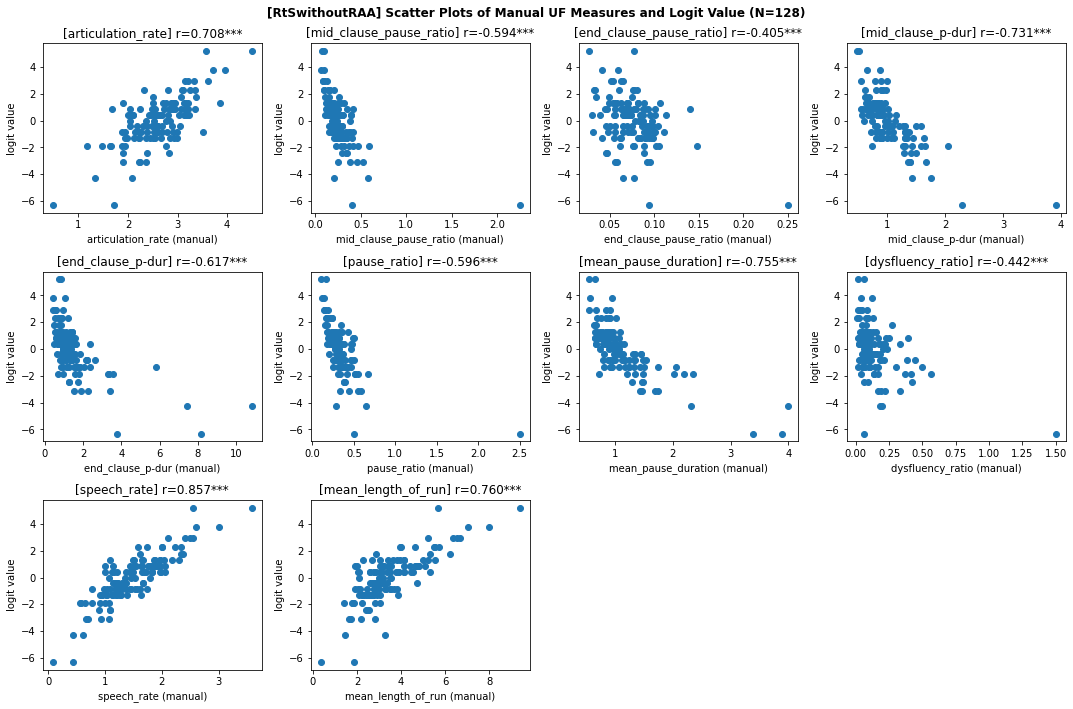

,r,p,sig
UF measures,,,
articulation_rate,0.707646,9.796397e-21,***
mid_clause_pause_ratio,-0.593659,1.521835e-13,***
end_clause_pause_ratio,-0.404772,2.148005e-06,***
mid_clause_p-dur,-0.730656,1.261558e-22,***
end_clause_p-dur,-0.616619,9.258499e-15,***
pause_ratio,-0.595654,1.203669e-13,***
mean_pause_duration,-0.754729,8.007664e-25,***
dysfluency_ratio,-0.441735,1.792429e-07,***
speech_rate,0.857058,4.243054e-38,***


In [23]:
task = "RtSwithoutRAA"
manual = True
task_facet = False
X, Y = load_dataset(task, manual, task_facet)
correlation_analysis(task, X, Y, manual)

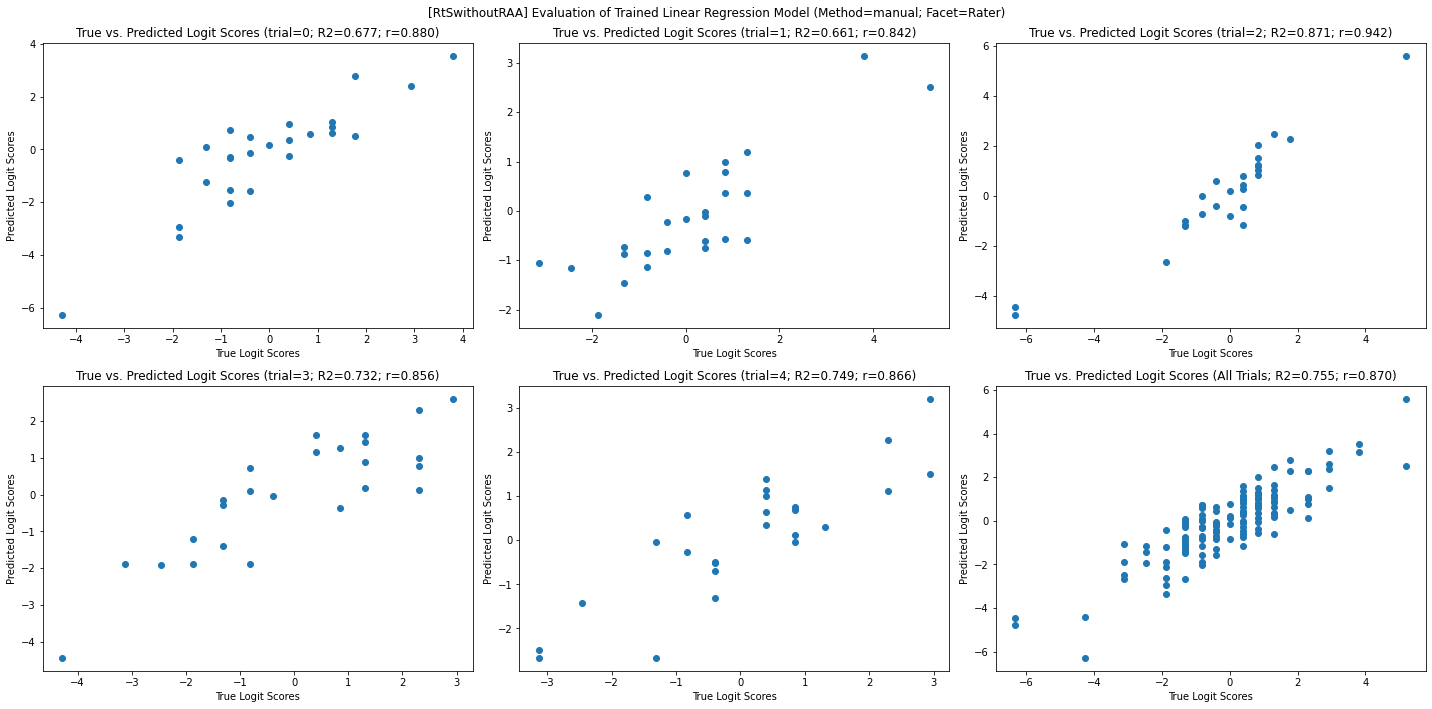

,task,method,facet,score,R2_lower,R2,R2_upper,r,articulation_rate_relimp_raw,articulation_rate_relimp_norm,...,mean_pause_duration_coef,dysfluency_ratio_relimp_raw,dysfluency_ratio_relimp_norm,dysfluency_ratio_coef,speech_rate_relimp_raw,speech_rate_relimp_norm,speech_rate_coef,mean_length_of_run_relimp_raw,mean_length_of_run_relimp_norm,mean_length_of_run_coef
name,,,,,,,,,,,,,,,,,,,,,
0 trial,RtSwithoutRAA,manual,Rater,0.816413,0.562751,0.676781,0.790812,0.879672,0.835465,3.443108,...,-2.255912,1.140845,4.701635,-0.494286,3.082757,12.704614,-0.104621,0.926910,3.819970,0.777577
1 trial,RtSwithoutRAA,manual,Rater,0.831391,0.542956,0.661121,0.779285,0.841999,0.165905,17.185265,...,-0.529877,0.046053,4.770381,0.087706,0.029527,3.058566,0.929061,0.308670,31.973555,0.425131
2 trial,RtSwithoutRAA,manual,Rater,0.763324,0.819426,0.871041,0.922655,0.941968,1.806201,5.562054,...,-1.009501,0.133213,0.410220,0.328984,1.360026,4.188095,2.021603,3.330120,10.254843,0.306709
3 trial,RtSwithoutRAA,manual,Rater,0.818542,0.634983,0.732096,0.829210,0.855869,0.380740,4.605375,...,-0.863913,0.229652,2.777840,0.877106,0.909564,11.001961,0.489526,0.489475,5.920620,0.472799
4 trial,RtSwithoutRAA,manual,Rater,0.814556,0.656855,0.748912,0.840969,0.865613,0.158170,16.433602,...,-0.373790,0.037912,3.939032,-0.250090,0.028655,2.977218,1.107923,0.309345,32.140485,0.421368
Average,RtSwithoutRAA,manual,Rater,NaN,0.643394,0.737990,0.832586,0.877024,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Concat,RtSwithoutRAA,manual,Rater,NaN,0.686746,0.754800,0.822853,0.870126,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
results, _, _ = train(X, Y, train_indices_list, test_indices_list)
df_eval = evaluate(task, results, manual, task_facet)
df_eval_list.append(df_eval)
df_eval

**Automatic Measures (Facet = Rater)**

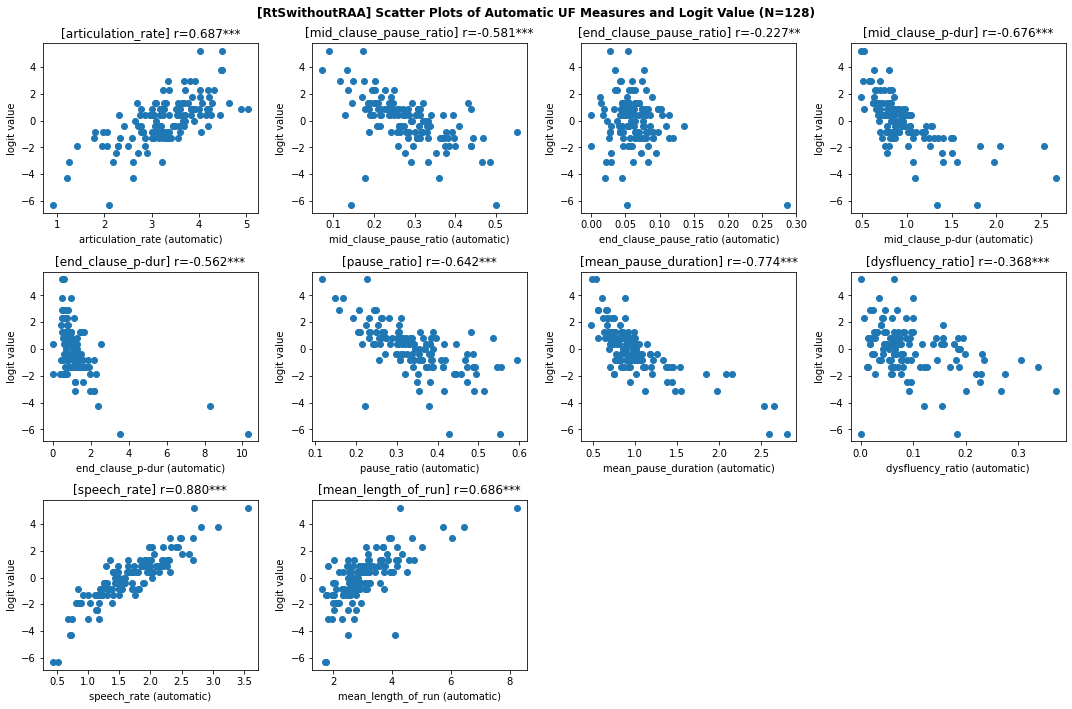

,r,p,sig
UF measures,,,
articulation_rate,0.687414,3.221056e-19,***
mid_clause_pause_ratio,-0.581083,6.433301e-13,***
end_clause_pause_ratio,-0.227178,9.913779e-03,**
mid_clause_p-dur,-0.676311,1.946307e-18,***
end_clause_p-dur,-0.561837,5.203693e-12,***
pause_ratio,-0.641717,3.302856e-16,***
mean_pause_duration,-0.773501,1.013421e-26,***
dysfluency_ratio,-0.367778,1.947896e-05,***
speech_rate,0.880160,1.353881e-42,***


In [25]:
task = "RtSwithoutRAA"
manual = False
task_facet = False
X, Y = load_dataset(task, manual, task_facet)
correlation_analysis(task, X, Y, manual)

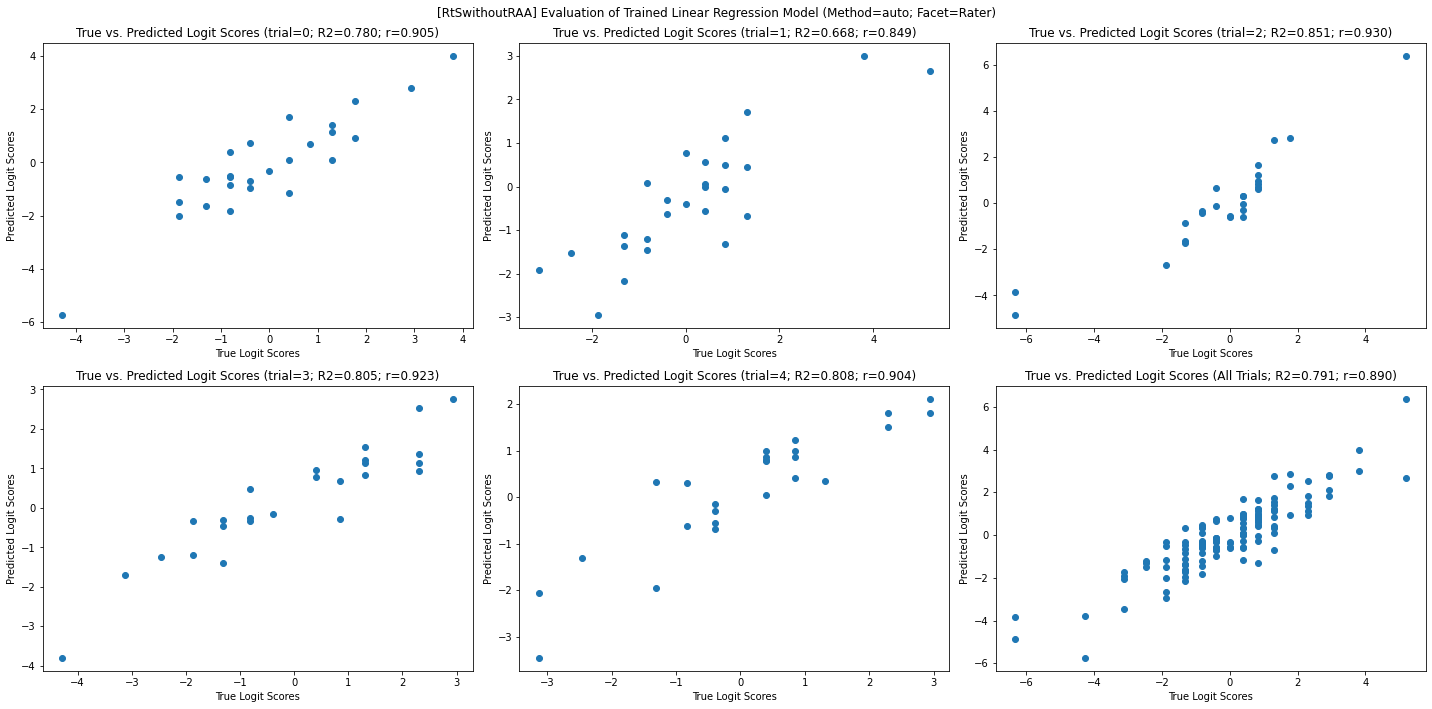

,task,method,facet,score,R2_lower,R2,R2_upper,r,articulation_rate_relimp_raw,articulation_rate_relimp_norm,...,mean_pause_duration_coef,dysfluency_ratio_relimp_raw,dysfluency_ratio_relimp_norm,dysfluency_ratio_coef,speech_rate_relimp_raw,speech_rate_relimp_norm,speech_rate_coef,mean_length_of_run_relimp_raw,mean_length_of_run_relimp_norm,mean_length_of_run_coef
name,,,,,,,,,,,,,,,,,,,,,
0 trial,RtSwithoutRAA,auto,Rater,0.847235,0.696075,0.779546,0.863018,0.904779,1.149437e-01,12.673427,...,-2.093608,3.515037e-02,3.875599,-0.720107,2.295646e-02,2.531127,2.093459,1.659967e-01,18.302418,0.315783
1 trial,RtSwithoutRAA,auto,Rater,0.870706,0.552252,0.668489,0.784726,0.849068,3.882993e-01,4.979476,...,-2.340032,4.034488e-02,0.517375,-0.603669,2.930698e-01,3.758271,1.502622,6.716567e-01,8.613197,0.304622
2 trial,RtSwithoutRAA,auto,Rater,0.804859,0.792558,0.851370,0.910182,0.929734,2.014050e+00,4.465766,...,-0.933579,4.339700e-02,0.096224,-1.667229,1.642376e+00,3.641652,2.911664,4.540341e+00,10.067329,0.351733
3 trial,RtSwithoutRAA,auto,Rater,0.844119,0.731507,0.805472,0.879437,0.922848,1.270259e+26,3.801860,...,-2.306995,9.353615e+24,0.279952,-1.514696,1.002213e+26,2.999603,1.241428,2.902839e+26,8.688142,0.619228
4 trial,RtSwithoutRAA,auto,Rater,0.843903,0.735004,0.808091,0.881179,0.904398,2.911075e+00,4.342102,...,-2.511574,1.639669e-01,0.244570,-1.091850,1.632359e+00,2.434795,1.390901,6.142743e+00,9.162394,0.487326
Average,RtSwithoutRAA,auto,Rater,NaN,0.701479,0.782594,0.863708,0.902165,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Concat,RtSwithoutRAA,auto,Rater,NaN,0.732080,0.791370,0.850660,0.889709,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
results, _, _ = train(X, Y, train_indices_list, test_indices_list)
df_eval = evaluate(task, results, manual, task_facet)
df_eval_list.append(df_eval)
df_eval

**Manual Measures (Facet = Rater, Task)**

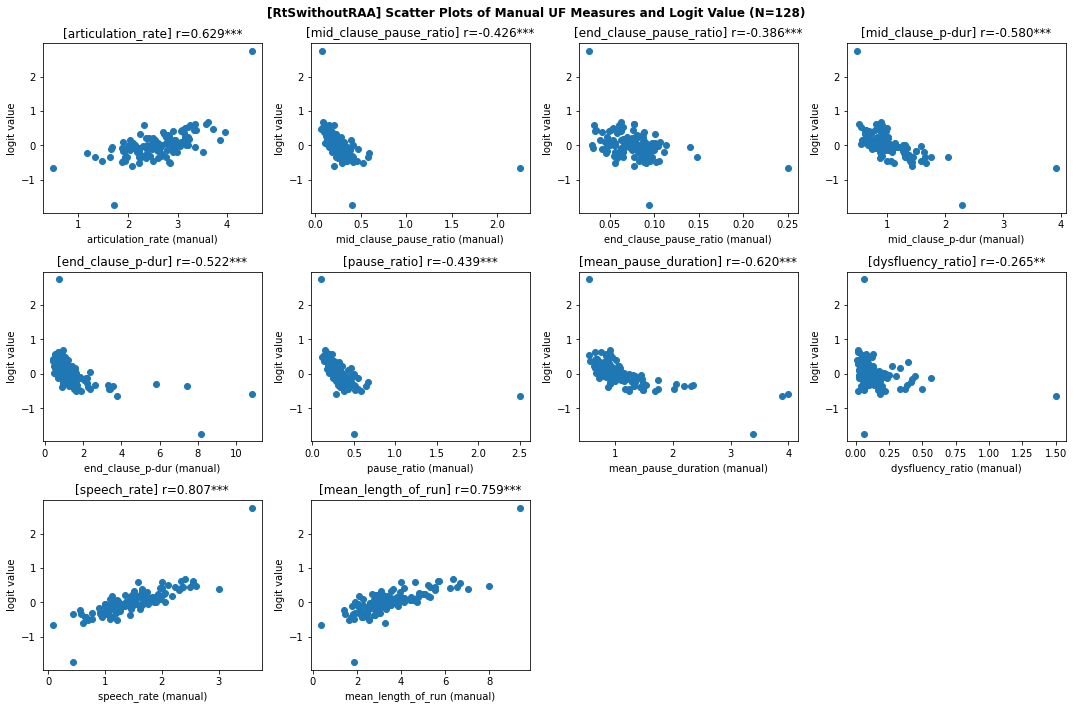

,r,p,sig
UF measures,,,
articulation_rate,0.628803,1.905982e-15,***
mid_clause_pause_ratio,-0.426200,5.277299e-07,***
end_clause_pause_ratio,-0.385831,6.866637e-06,***
mid_clause_p-dur,-0.579820,7.410111e-13,***
end_clause_p-dur,-0.522086,2.613386e-10,***
pause_ratio,-0.438945,2.184727e-07,***
mean_pause_duration,-0.620426,5.691956e-15,***
dysfluency_ratio,-0.264922,2.510809e-03,**
speech_rate,0.807011,1.315930e-30,***


In [27]:
task = "RtSwithoutRAA"
manual = True
task_facet = True
X, Y = load_dataset(task, manual, task_facet)
correlation_analysis(task, X, Y, manual)

/tmp/ipykernel_992402/1271605277.py:5: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(bunshi/bunbo)


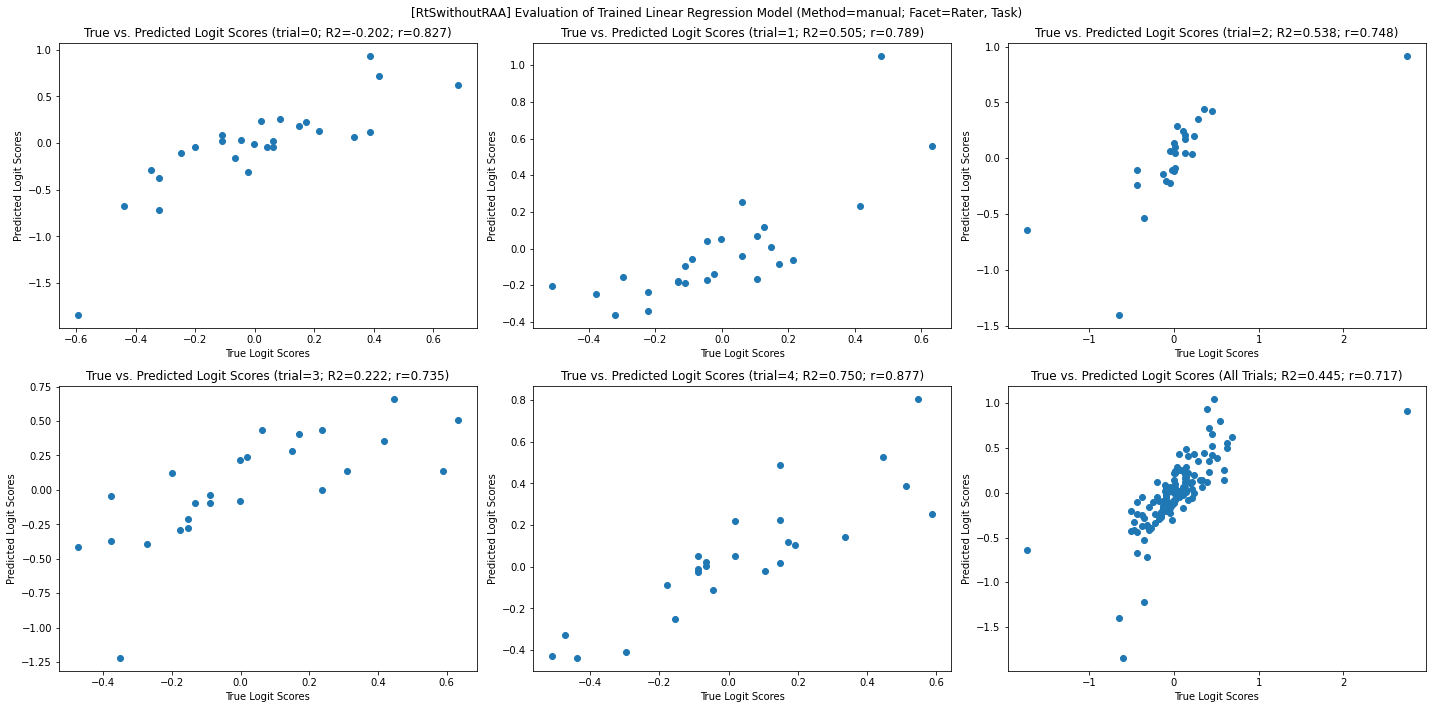

,task,method,facet,score,R2_lower,R2,R2_upper,r,articulation_rate_relimp_raw,articulation_rate_relimp_norm,...,mean_pause_duration_coef,dysfluency_ratio_relimp_raw,dysfluency_ratio_relimp_norm,dysfluency_ratio_coef,speech_rate_relimp_raw,speech_rate_relimp_norm,speech_rate_coef,mean_length_of_run_relimp_raw,mean_length_of_run_relimp_norm,mean_length_of_run_coef
name,,,,,,,,,,,,,,,,,,,,,
0 trial,RtSwithoutRAA,manual,"Rater, Task",0.745935,NaN,-0.202264,NaN,0.827364,5.742803e+24,0.844323,...,-1.084501,3.357439e+25,4.936202,0.147754,8.946531e+25,13.153444,-0.119032,1.993762e+25,2.931286,0.247349
1 trial,RtSwithoutRAA,manual,"Rater, Task",0.725445,0.353793,0.504693,0.655593,0.789050,1.937188e-01,20.016611,...,-0.314304,4.347905e-02,4.492612,0.240149,3.220756e-02,3.327949,-0.231862,2.921604e-01,30.188404,0.267790
2 trial,RtSwithoutRAA,manual,"Rater, Task",0.754999,0.392245,0.537634,0.683022,0.748148,1.987734e-01,14.632800,...,-0.377855,3.764828e-02,2.771497,0.263226,5.400463e-02,3.975577,0.449609,2.243895e-01,16.518539,0.022698
3 trial,RtSwithoutRAA,manual,"Rater, Task",0.737104,0.066495,0.221759,0.377024,0.735371,9.948278e+25,0.924731,...,0.317459,3.014688e+26,2.802270,0.341322,1.315257e+27,12.225831,-0.069367,2.747066e+26,2.553505,0.198005
4 trial,RtSwithoutRAA,manual,"Rater, Task",0.706278,0.658386,0.750085,0.841784,0.876780,1.825871e-01,18.929174,...,-0.188387,3.569285e-02,3.700350,0.017834,3.093756e-02,3.207359,-0.053522,2.943943e-01,30.520455,0.232944
Average,RtSwithoutRAA,manual,"Rater, Task",NaN,NaN,0.362381,NaN,0.795342,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Concat,RtSwithoutRAA,manual,"Rater, Task",NaN,0.326585,0.444869,0.563152,0.717179,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
results, _, _ = train(X, Y, train_indices_list, test_indices_list)
df_eval = evaluate(task, results, manual, task_facet)
df_eval_list.append(df_eval)
df_eval

**Automatic Measures (Facet = Rater, Task)**

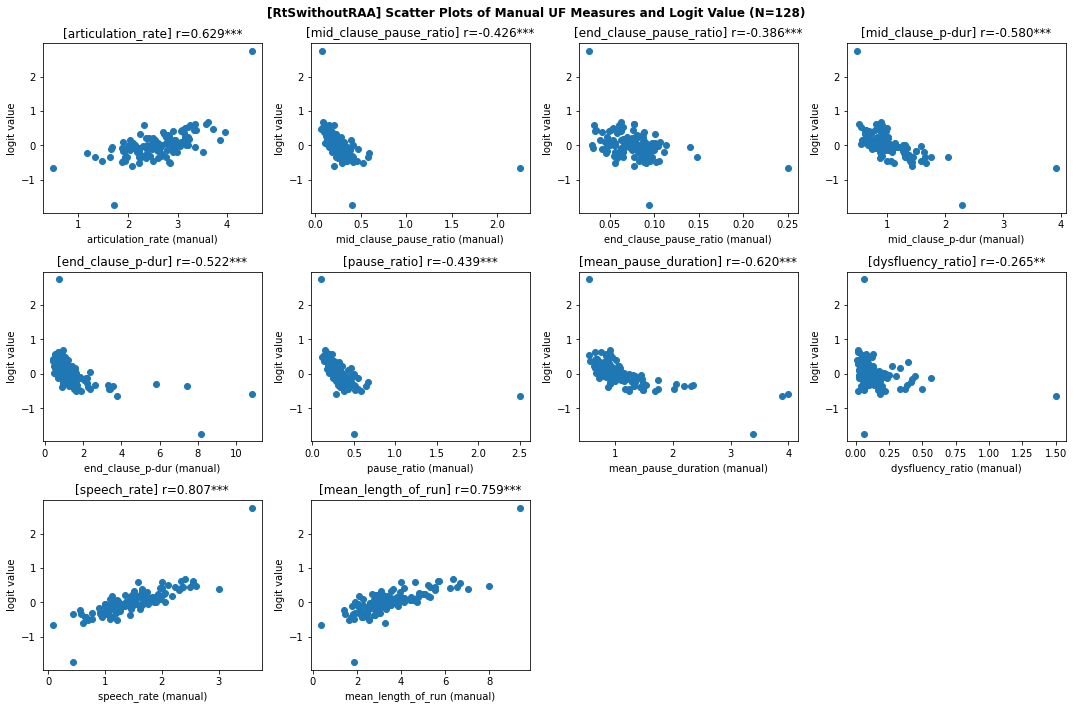

,r,p,sig
UF measures,,,
articulation_rate,0.628803,1.905982e-15,***
mid_clause_pause_ratio,-0.426200,5.277299e-07,***
end_clause_pause_ratio,-0.385831,6.866637e-06,***
mid_clause_p-dur,-0.579820,7.410111e-13,***
end_clause_p-dur,-0.522086,2.613386e-10,***
pause_ratio,-0.438945,2.184727e-07,***
mean_pause_duration,-0.620426,5.691956e-15,***
dysfluency_ratio,-0.264922,2.510809e-03,**
speech_rate,0.807011,1.315930e-30,***


In [29]:
task = "RtSwithoutRAA"
manual = True
task_facet = True
X, Y = load_dataset(task, manual, task_facet)
correlation_analysis(task, X, Y, manual)

/tmp/ipykernel_992402/1271605277.py:5: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(bunshi/bunbo)


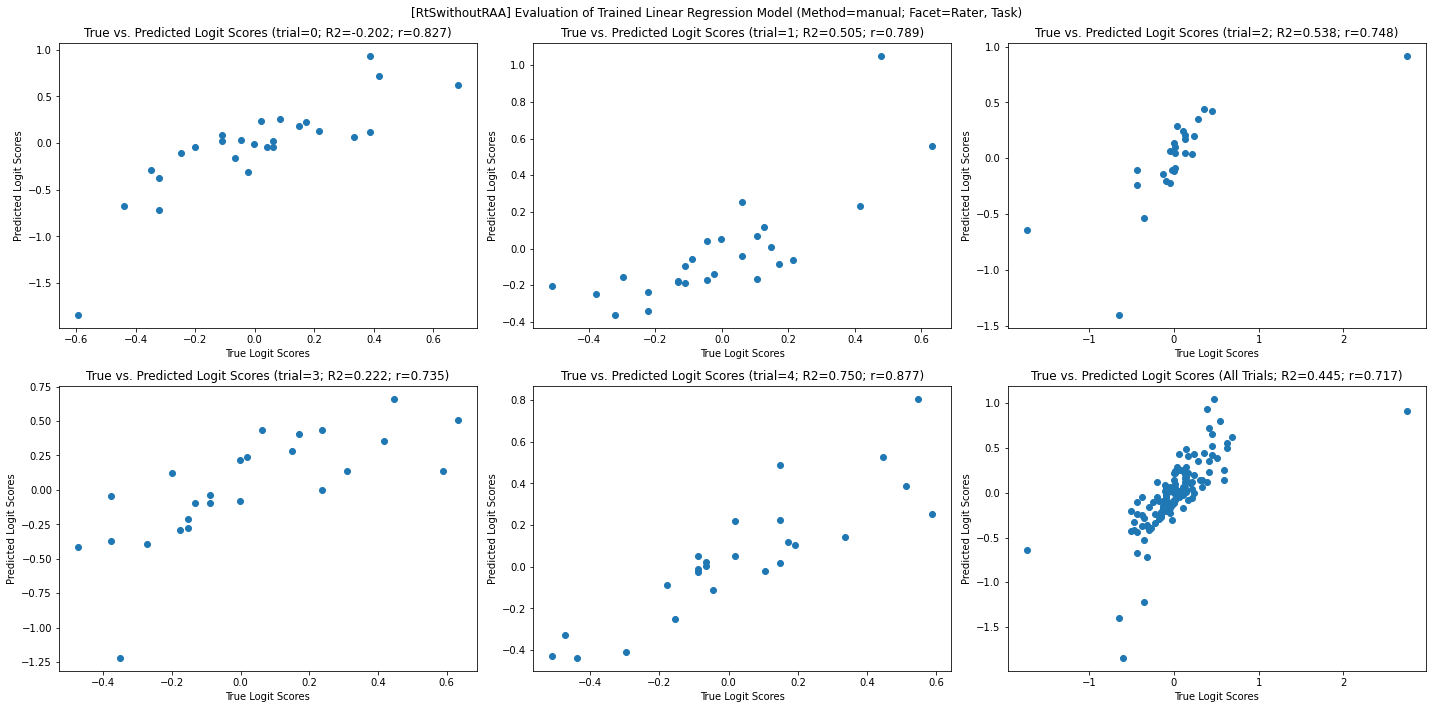

,task,method,facet,score,R2_lower,R2,R2_upper,r,articulation_rate_relimp_raw,articulation_rate_relimp_norm,...,mean_pause_duration_coef,dysfluency_ratio_relimp_raw,dysfluency_ratio_relimp_norm,dysfluency_ratio_coef,speech_rate_relimp_raw,speech_rate_relimp_norm,speech_rate_coef,mean_length_of_run_relimp_raw,mean_length_of_run_relimp_norm,mean_length_of_run_coef
name,,,,,,,,,,,,,,,,,,,,,
0 trial,RtSwithoutRAA,manual,"Rater, Task",0.745935,NaN,-0.202264,NaN,0.827364,5.742803e+24,0.844323,...,-1.084501,3.357439e+25,4.936202,0.147754,8.946531e+25,13.153444,-0.119032,1.993762e+25,2.931286,0.247349
1 trial,RtSwithoutRAA,manual,"Rater, Task",0.725445,0.353793,0.504693,0.655593,0.789050,1.937188e-01,20.016611,...,-0.314304,4.347905e-02,4.492612,0.240149,3.220756e-02,3.327949,-0.231862,2.921604e-01,30.188404,0.267790
2 trial,RtSwithoutRAA,manual,"Rater, Task",0.754999,0.392245,0.537634,0.683022,0.748148,1.987734e-01,14.632800,...,-0.377855,3.764828e-02,2.771497,0.263226,5.400463e-02,3.975577,0.449609,2.243895e-01,16.518539,0.022698
3 trial,RtSwithoutRAA,manual,"Rater, Task",0.737104,0.066495,0.221759,0.377024,0.735371,9.948278e+25,0.924731,...,0.317459,3.014688e+26,2.802270,0.341322,1.315257e+27,12.225831,-0.069367,2.747066e+26,2.553505,0.198005
4 trial,RtSwithoutRAA,manual,"Rater, Task",0.706278,0.658386,0.750085,0.841784,0.876780,1.825871e-01,18.929174,...,-0.188387,3.569285e-02,3.700350,0.017834,3.093756e-02,3.207359,-0.053522,2.943943e-01,30.520455,0.232944
Average,RtSwithoutRAA,manual,"Rater, Task",NaN,NaN,0.362381,NaN,0.795342,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Concat,RtSwithoutRAA,manual,"Rater, Task",NaN,0.326585,0.444869,0.563152,0.717179,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
results, _, _ = train(X, Y, train_indices_list, test_indices_list)
df_eval = evaluate(task, results, manual, task_facet)
df_eval_list.append(df_eval)
df_eval

### 3.4. RtSwithRAA

**Manual Measures (Facet = Rater)**

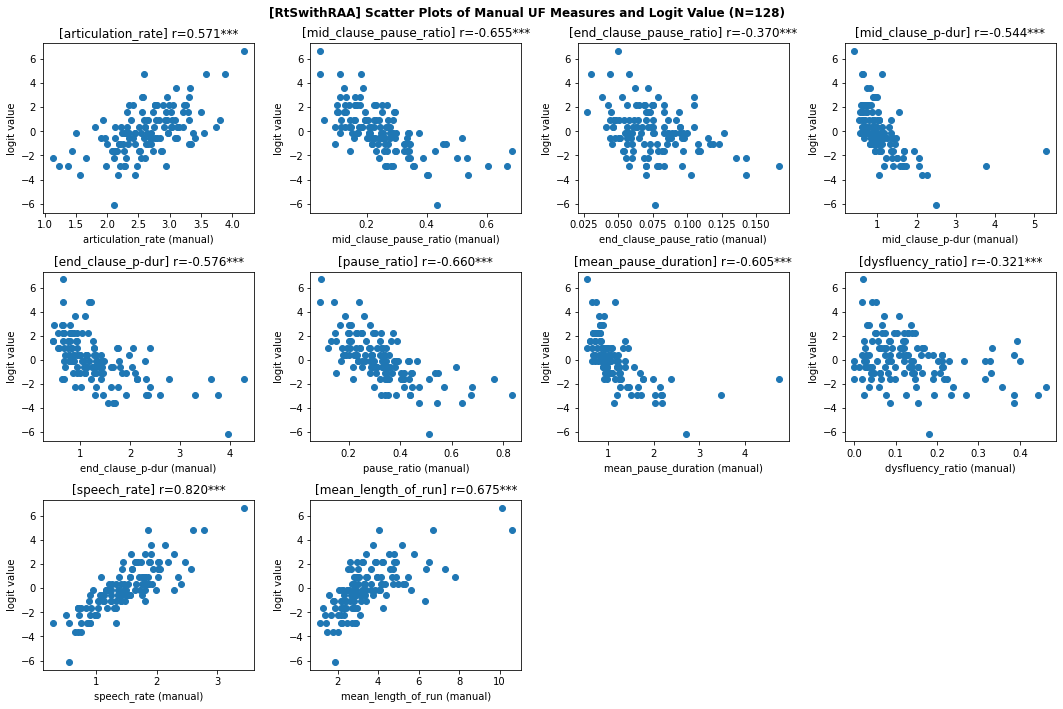

,r,p,sig
UF measures,,,
articulation_rate,0.571047,1.946264e-12,***
mid_clause_pause_ratio,-0.654776,5.144129e-17,***
end_clause_pause_ratio,-0.369885,1.730162e-05,***
mid_clause_p-dur,-0.544019,3.208413e-11,***
end_clause_p-dur,-0.575704,1.169917e-12,***
pause_ratio,-0.660276,2.286602e-17,***
mean_pause_duration,-0.605303,3.783812e-14,***
dysfluency_ratio,-0.320590,2.248279e-04,***
speech_rate,0.819913,2.594754e-32,***


In [31]:
task = "RtSwithRAA"
manual = True
task_facet = False
X, Y = load_dataset(task, manual, task_facet)
correlation_analysis(task, X, Y, manual)

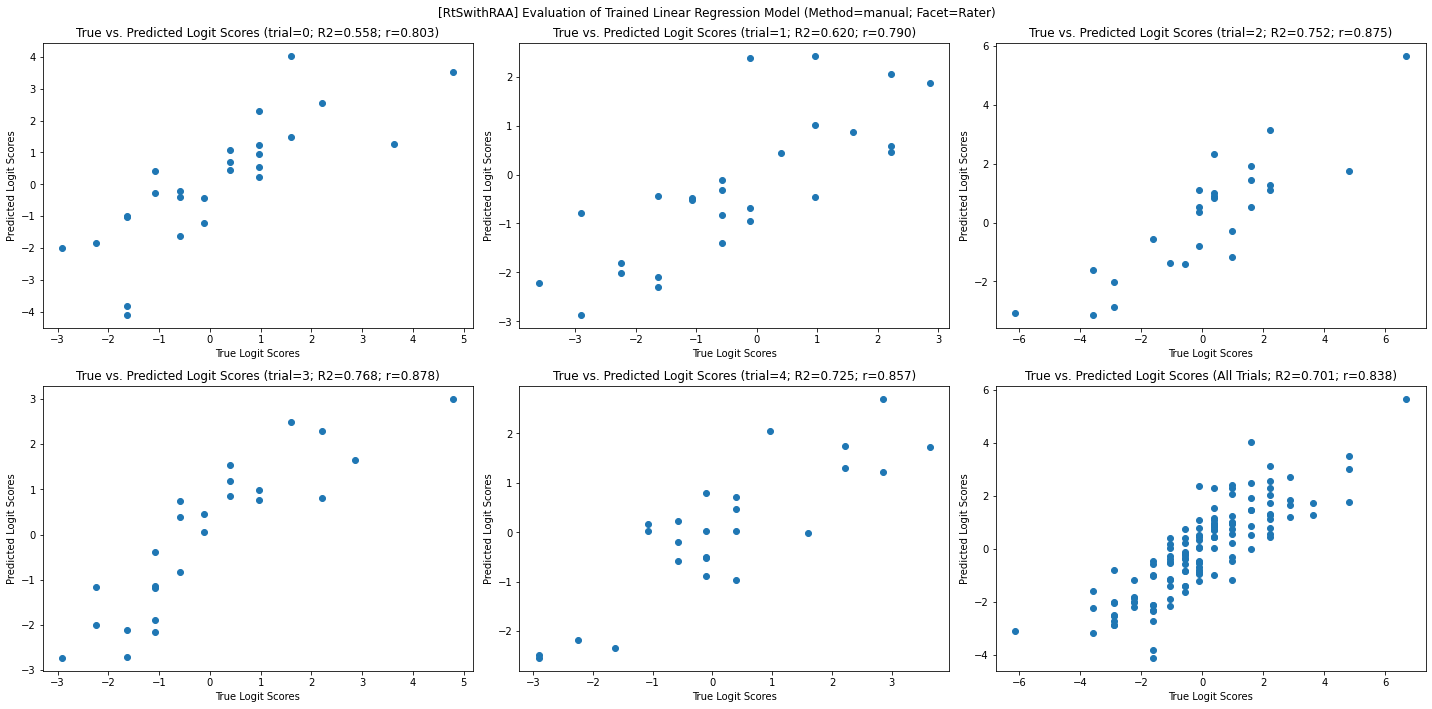

,task,method,facet,score,R2_lower,R2,R2_upper,r,articulation_rate_relimp_raw,articulation_rate_relimp_norm,...,mean_pause_duration_coef,dysfluency_ratio_relimp_raw,dysfluency_ratio_relimp_norm,dysfluency_ratio_coef,speech_rate_relimp_raw,speech_rate_relimp_norm,speech_rate_coef,mean_length_of_run_relimp_raw,mean_length_of_run_relimp_norm,mean_length_of_run_coef
name,,,,,,,,,,,,,,,,,,,,,
0 trial,RtSwithRAA,manual,Rater,0.763830,0.415922,0.557593,0.699264,0.803347,5.389170,4.787567,...,-3.943931,1.750099,1.554732,1.254968,4.817643,4.279840,3.598176,10.332445,9.179015,0.021711
1 trial,RtSwithRAA,manual,Rater,0.760895,0.492088,0.620327,0.748566,0.789895,0.213031,5.990041,...,-1.235577,0.042452,1.193684,-0.416439,0.131842,3.707139,4.179527,0.448730,12.617440,-0.100792
2 trial,RtSwithRAA,manual,Rater,0.731306,0.660208,0.752332,0.844457,0.874937,0.283610,6.706660,...,-4.779096,0.033861,0.800728,0.272521,0.116167,2.747046,4.327665,0.542531,12.829474,-0.105505
3 trial,RtSwithRAA,manual,Rater,0.738217,0.681515,0.767735,0.853954,0.878140,0.114597,12.619690,...,-3.134272,0.030463,3.354666,0.062763,0.033066,3.641322,4.170077,0.217717,23.975457,-0.132793
4 trial,RtSwithRAA,manual,Rater,0.744783,0.625870,0.725055,0.824241,0.857088,0.116271,12.826364,...,-2.905332,0.028529,3.147167,-1.111090,0.029552,3.259960,4.204587,0.204015,22.505684,-0.082517
Average,RtSwithRAA,manual,Rater,NaN,0.575121,0.684609,0.794096,0.840681,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Concat,RtSwithRAA,manual,Rater,NaN,0.620965,0.700949,0.780933,0.838111,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
results, _, _ = train(X, Y, train_indices_list, test_indices_list)
df_eval = evaluate(task, results, manual, task_facet)
df_eval_list.append(df_eval)
df_eval

**Automatic Measures (Facet = Rater)**

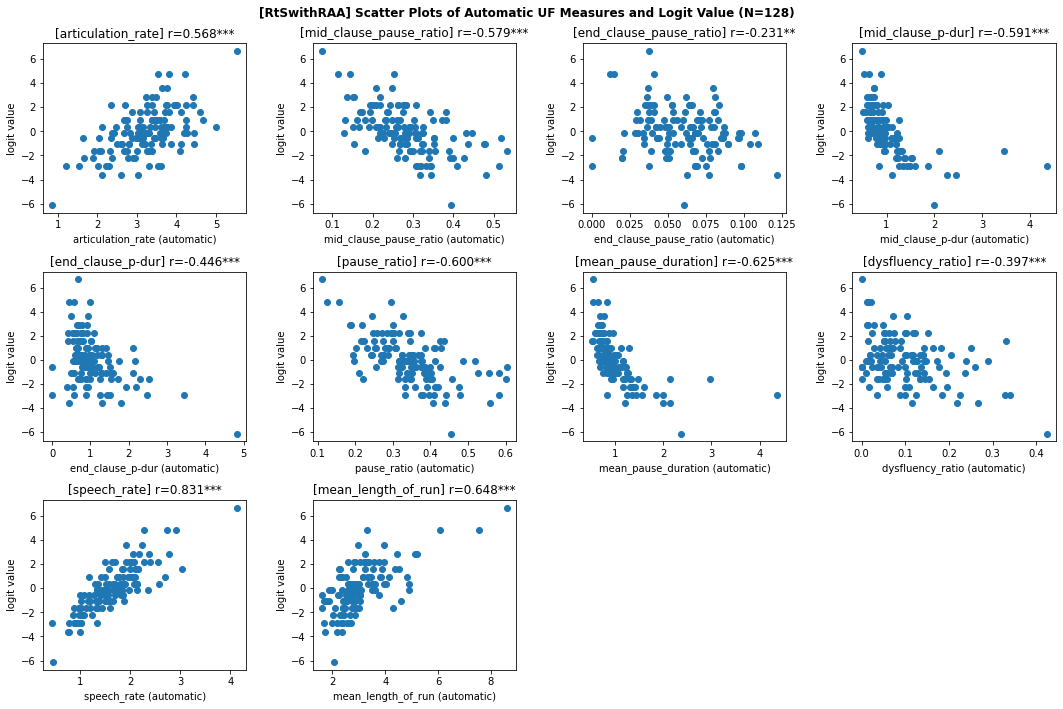

,r,p,sig
UF measures,,,
articulation_rate,0.568191,2.648758e-12,***
mid_clause_pause_ratio,-0.578684,8.411201e-13,***
end_clause_pause_ratio,-0.230926,8.727659e-03,**
mid_clause_p-dur,-0.590834,2.115092e-13,***
end_clause_p-dur,-0.445985,1.321353e-07,***
pause_ratio,-0.600189,7.020924e-14,***
mean_pause_duration,-0.624923,3.176524e-15,***
dysfluency_ratio,-0.397249,3.437366e-06,***
speech_rate,0.830991,6.876477e-34,***


In [33]:
task = "RtSwithRAA"
manual = False
task_facet = False
X, Y = load_dataset(task, manual, task_facet)
correlation_analysis(task, X, Y, manual)

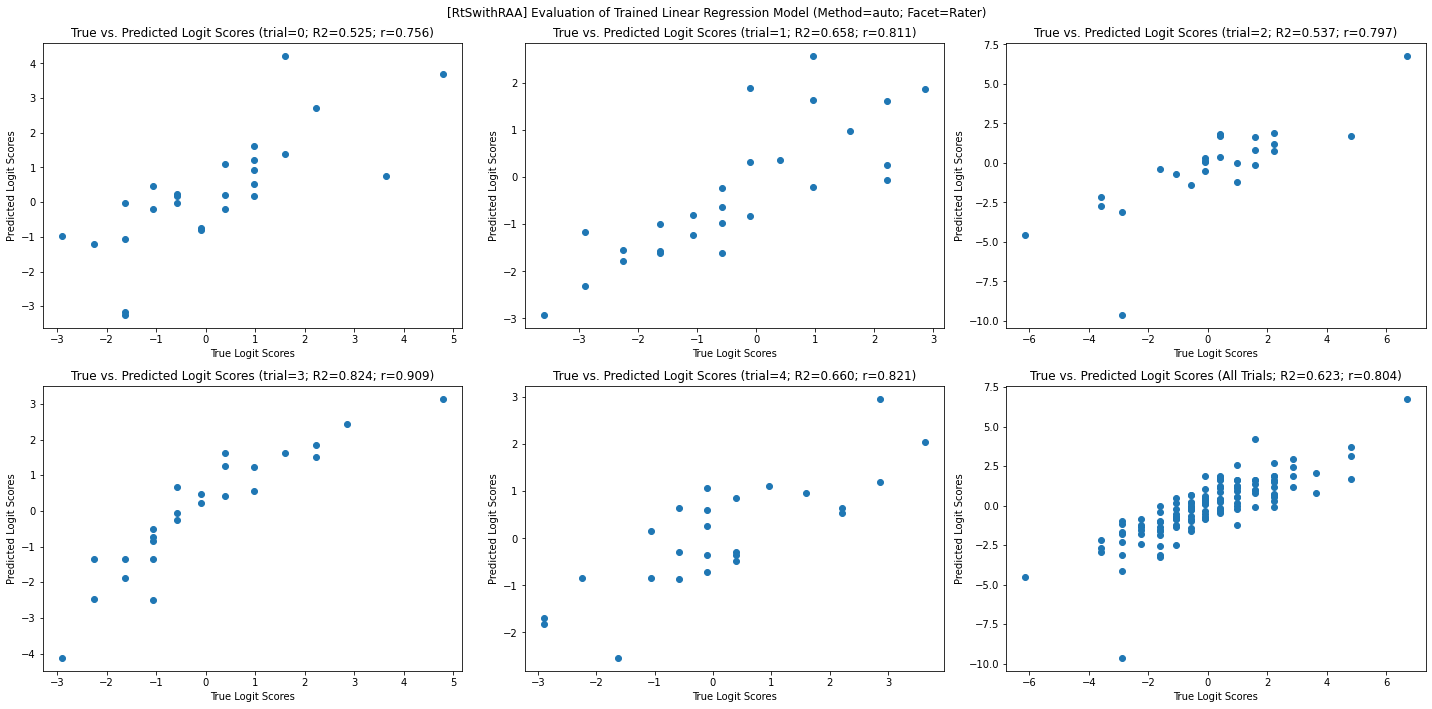

,task,method,facet,score,R2_lower,R2,R2_upper,r,articulation_rate_relimp_raw,articulation_rate_relimp_norm,...,mean_pause_duration_coef,dysfluency_ratio_relimp_raw,dysfluency_ratio_relimp_norm,dysfluency_ratio_coef,speech_rate_relimp_raw,speech_rate_relimp_norm,speech_rate_coef,mean_length_of_run_relimp_raw,mean_length_of_run_relimp_norm,mean_length_of_run_coef
name,,,,,,,,,,,,,,,,,,,,,
0 trial,RtSwithRAA,auto,Rater,0.780887,0.377760,0.525304,0.672848,0.755950,1.360190,4.482319,...,0.244882,0.066150,0.217987,0.419015,0.891377,2.937412,3.153286,2.911200,9.593460,-0.095959
1 trial,RtSwithRAA,auto,Rater,0.760203,0.539403,0.658297,0.777191,0.811370,0.108039,12.136350,...,-0.837179,0.022178,2.491284,-0.458785,0.038084,4.278076,2.972749,0.177694,19.961038,-0.023512
2 trial,RtSwithRAA,auto,Rater,0.733822,0.392034,0.537455,0.682875,0.797460,0.105851,11.562569,...,-5.993584,0.030658,3.348893,0.980222,0.029098,3.178515,1.003258,0.164193,17.935527,0.592006
3 trial,RtSwithRAA,auto,Rater,0.731511,0.755649,0.823504,0.891360,0.909297,6.289194,4.154599,...,-0.838163,0.084882,0.056073,-0.602165,3.611407,2.385671,3.028766,13.116468,8.664649,-0.158145
4 trial,RtSwithRAA,auto,Rater,0.761011,0.542489,0.659611,0.776732,0.820792,0.102281,11.504474,...,-0.899053,0.023752,2.671609,-0.361644,0.037627,4.232281,2.509320,0.176600,19.863815,0.115729
Average,RtSwithRAA,auto,Rater,NaN,0.521467,0.640834,0.760201,0.818974,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Concat,RtSwithRAA,auto,Rater,NaN,0.527394,0.622536,0.717677,0.803844,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
results, _, _ = train(X, Y, train_indices_list, test_indices_list)
df_eval = evaluate(task, results, manual, task_facet)
df_eval_list.append(df_eval)
df_eval

**Manual Measures (Facet = Rater, Task)**

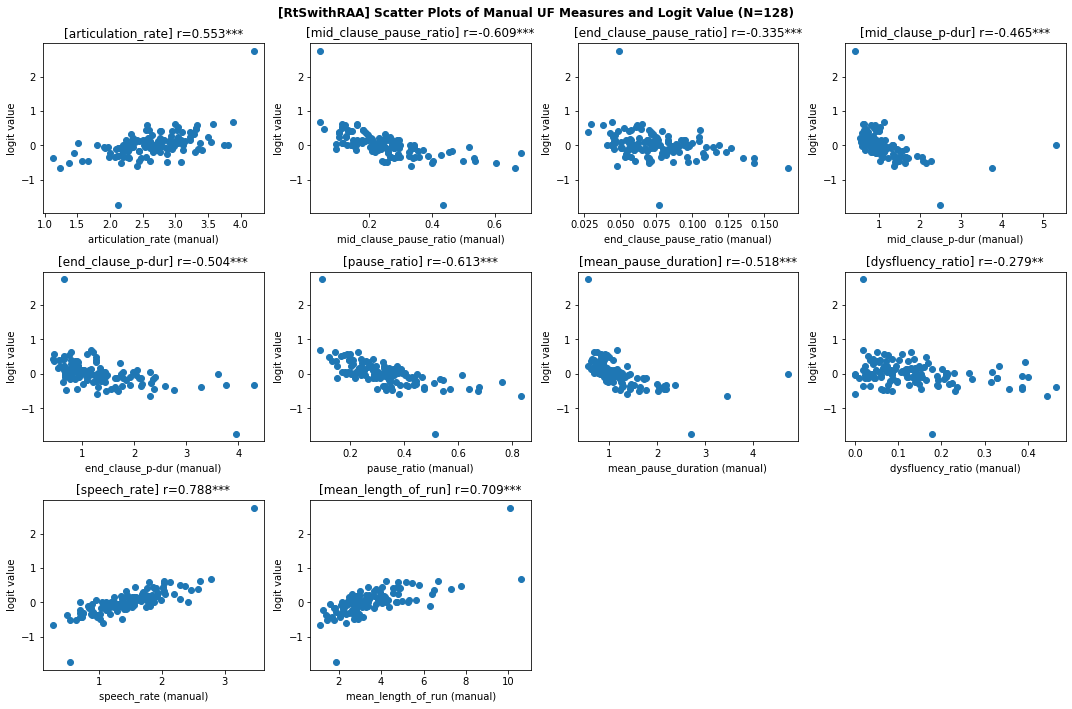

,r,p,sig
UF measures,,,
articulation_rate,0.552551,1.360940e-11,***
mid_clause_pause_ratio,-0.609299,2.316375e-14,***
end_clause_pause_ratio,-0.335342,1.091021e-04,***
mid_clause_p-dur,-0.464996,3.206850e-08,***
end_clause_p-dur,-0.504433,1.272262e-09,***
pause_ratio,-0.612771,1.503749e-14,***
mean_pause_duration,-0.517539,3.963383e-10,***
dysfluency_ratio,-0.279294,1.409787e-03,**
speech_rate,0.788356,2.343975e-28,***


In [35]:
task = "RtSwithRAA"
manual = True
task_facet = True
X, Y = load_dataset(task, manual, task_facet)
correlation_analysis(task, X, Y, manual)

/tmp/ipykernel_992402/1271605277.py:5: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(bunshi/bunbo)


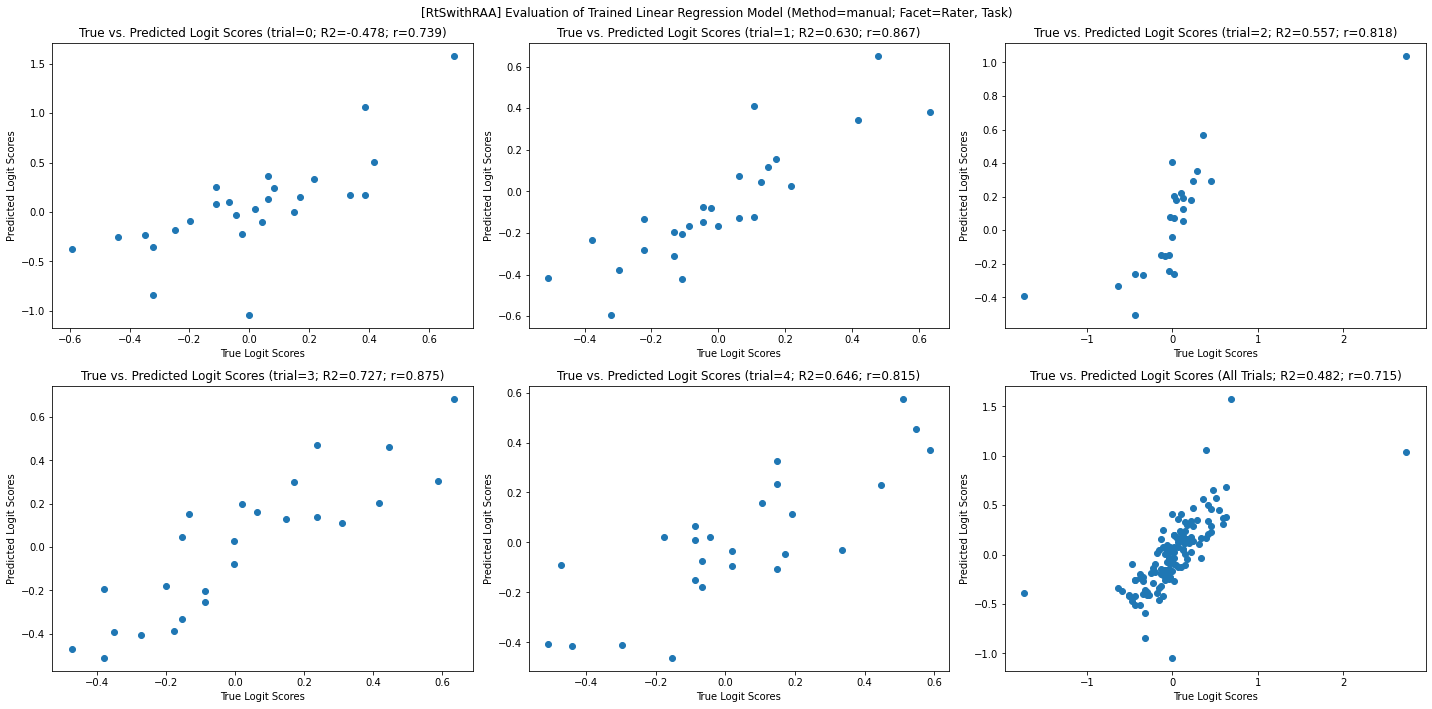

,task,method,facet,score,R2_lower,R2,R2_upper,r,articulation_rate_relimp_raw,articulation_rate_relimp_norm,...,mean_pause_duration_coef,dysfluency_ratio_relimp_raw,dysfluency_ratio_relimp_norm,dysfluency_ratio_coef,speech_rate_relimp_raw,speech_rate_relimp_norm,speech_rate_coef,mean_length_of_run_relimp_raw,mean_length_of_run_relimp_norm,mean_length_of_run_coef
name,,,,,,,,,,,,,,,,,,,,,
0 trial,RtSwithRAA,manual,"Rater, Task",0.740942,NaN,-0.478466,NaN,0.738832,4.162005e+23,3.638587,...,-0.971805,1.884027e+23,1.647090,0.328151,4.869824e+23,4.257390,0.096914,1.058844e+24,9.256823,0.243207
1 trial,RtSwithRAA,manual,"Rater, Task",0.688630,0.504118,0.630049,0.755979,0.866965,2.652954e+22,7.951000,...,-0.468927,2.463686e+21,0.738375,0.207064,1.424457e+22,4.269149,0.746482,3.751732e+22,11.244077,0.065568
2 trial,RtSwithRAA,manual,"Rater, Task",0.767518,0.415783,0.557477,0.699170,0.817540,1.009998e+00,8.695233,...,-1.038719,5.024630e-02,0.432578,0.180136,3.215267e-01,2.768074,0.788696,1.248855e+00,10.751589,-0.005437
3 trial,RtSwithRAA,manual,"Rater, Task",0.679642,0.628854,0.727363,0.825872,0.874950,1.454879e-01,16.012106,...,-0.244915,2.943441e-02,3.239491,0.049537,3.301215e-02,3.633250,0.775582,2.010293e-01,22.124871,0.048824
4 trial,RtSwithRAA,manual,"Rater, Task",0.689071,0.525130,0.645736,0.766343,0.814921,1.426788e-01,15.706001,...,-0.433262,2.760853e-02,3.039132,-0.172794,2.956038e-02,3.253990,0.686769,1.909901e-01,21.024086,0.070824
Average,RtSwithRAA,manual,"Rater, Task",NaN,NaN,0.416432,NaN,0.822642,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Concat,RtSwithRAA,manual,"Rater, Task",NaN,0.366957,0.481857,0.596758,0.715326,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
results, _, _ = train(X, Y, train_indices_list, test_indices_list)
df_eval = evaluate(task, results, manual, task_facet)
df_eval_list.append(df_eval)
df_eval

**Automatic Measures (Facet = Rater, Task)**

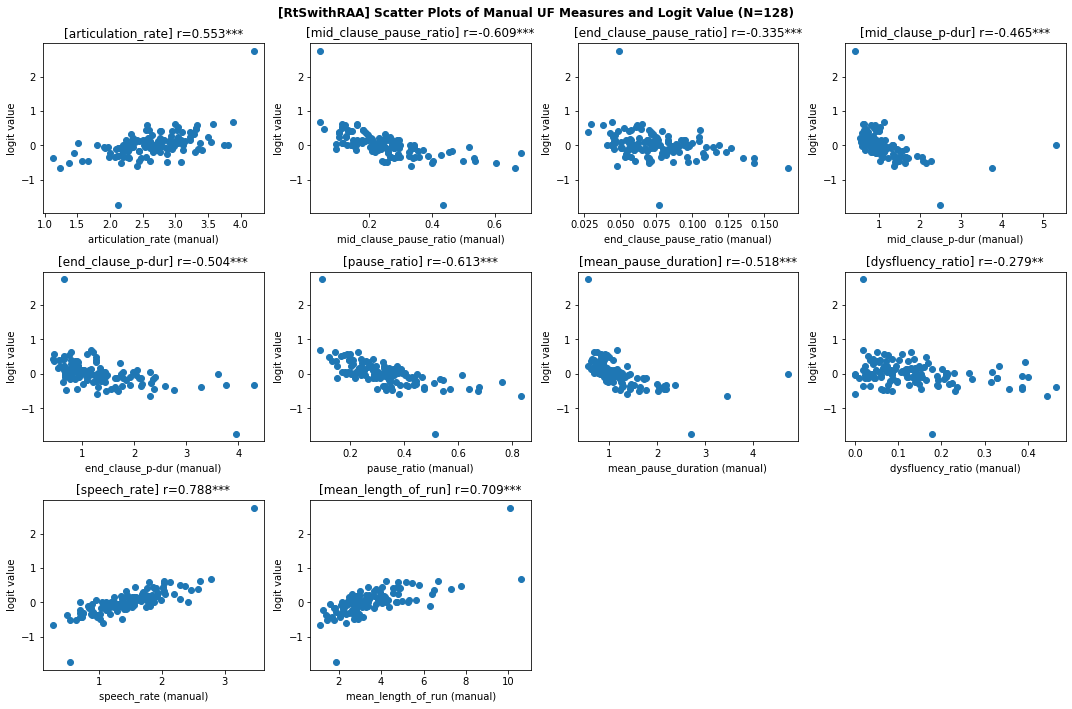

,r,p,sig
UF measures,,,
articulation_rate,0.552551,1.360940e-11,***
mid_clause_pause_ratio,-0.609299,2.316375e-14,***
end_clause_pause_ratio,-0.335342,1.091021e-04,***
mid_clause_p-dur,-0.464996,3.206850e-08,***
end_clause_p-dur,-0.504433,1.272262e-09,***
pause_ratio,-0.612771,1.503749e-14,***
mean_pause_duration,-0.517539,3.963383e-10,***
dysfluency_ratio,-0.279294,1.409787e-03,**
speech_rate,0.788356,2.343975e-28,***


In [37]:
task = "RtSwithRAA"
manual = True
task_facet = True
X, Y = load_dataset(task, manual, task_facet)
correlation_analysis(task, X, Y, manual)

/tmp/ipykernel_992402/1271605277.py:5: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(bunshi/bunbo)


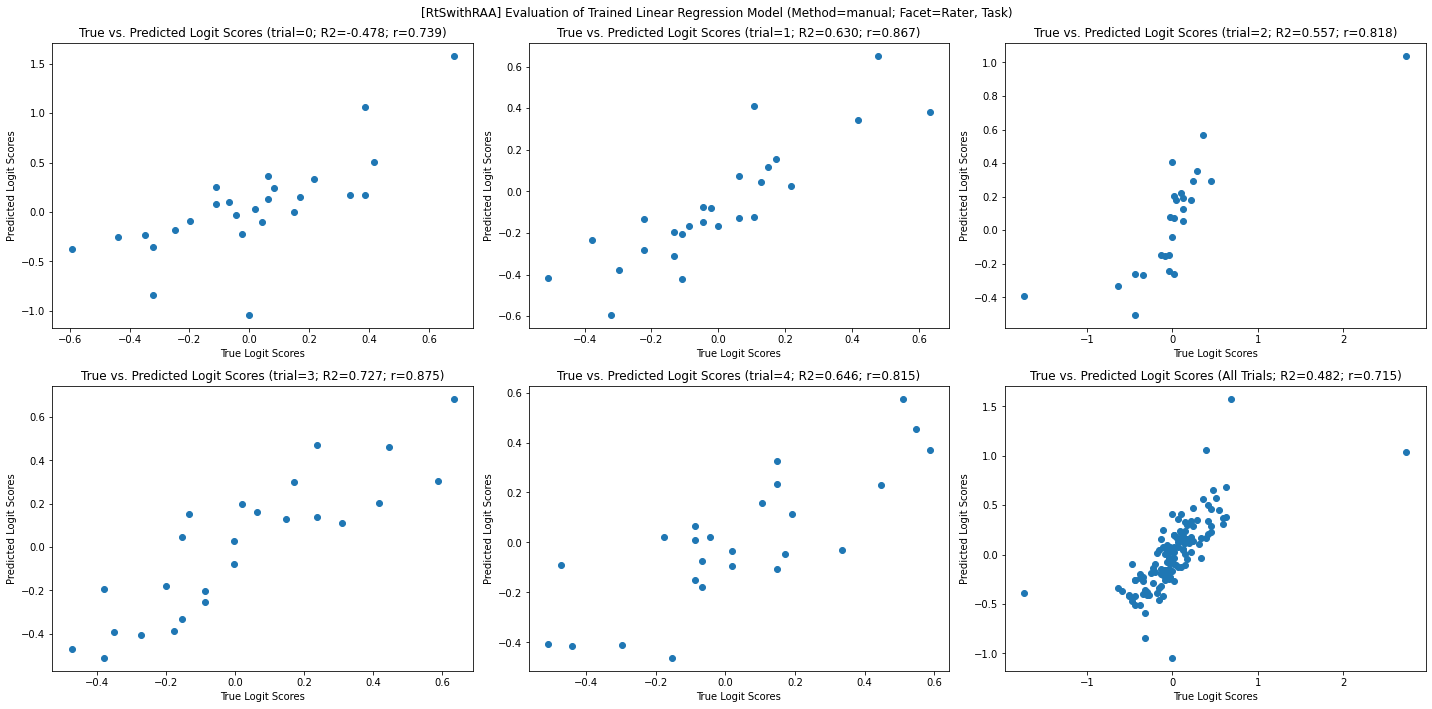

,task,method,facet,score,R2_lower,R2,R2_upper,r,articulation_rate_relimp_raw,articulation_rate_relimp_norm,...,mean_pause_duration_coef,dysfluency_ratio_relimp_raw,dysfluency_ratio_relimp_norm,dysfluency_ratio_coef,speech_rate_relimp_raw,speech_rate_relimp_norm,speech_rate_coef,mean_length_of_run_relimp_raw,mean_length_of_run_relimp_norm,mean_length_of_run_coef
name,,,,,,,,,,,,,,,,,,,,,
0 trial,RtSwithRAA,manual,"Rater, Task",0.740942,NaN,-0.478466,NaN,0.738832,4.162005e+23,3.638587,...,-0.971805,1.884027e+23,1.647090,0.328151,4.869824e+23,4.257390,0.096914,1.058844e+24,9.256823,0.243207
1 trial,RtSwithRAA,manual,"Rater, Task",0.688630,0.504118,0.630049,0.755979,0.866965,2.652954e+22,7.951000,...,-0.468927,2.463686e+21,0.738375,0.207064,1.424457e+22,4.269149,0.746482,3.751732e+22,11.244077,0.065568
2 trial,RtSwithRAA,manual,"Rater, Task",0.767518,0.415783,0.557477,0.699170,0.817540,1.009998e+00,8.695233,...,-1.038719,5.024630e-02,0.432578,0.180136,3.215267e-01,2.768074,0.788696,1.248855e+00,10.751589,-0.005437
3 trial,RtSwithRAA,manual,"Rater, Task",0.679642,0.628854,0.727363,0.825872,0.874950,1.454879e-01,16.012106,...,-0.244915,2.943441e-02,3.239491,0.049537,3.301215e-02,3.633250,0.775582,2.010293e-01,22.124871,0.048824
4 trial,RtSwithRAA,manual,"Rater, Task",0.689071,0.525130,0.645736,0.766343,0.814921,1.426788e-01,15.706001,...,-0.433262,2.760853e-02,3.039132,-0.172794,2.956038e-02,3.253990,0.686769,1.909901e-01,21.024086,0.070824
Average,RtSwithRAA,manual,"Rater, Task",NaN,NaN,0.416432,NaN,0.822642,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Concat,RtSwithRAA,manual,"Rater, Task",NaN,0.366957,0.481857,0.596758,0.715326,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
results, _, _ = train(X, Y, train_indices_list, test_indices_list)
df_eval = evaluate(task, results, manual, task_facet)
df_eval_list.append(df_eval)
df_eval

### 3.5. WoZ Interview

**Manual Measures (Facet = Rater)**

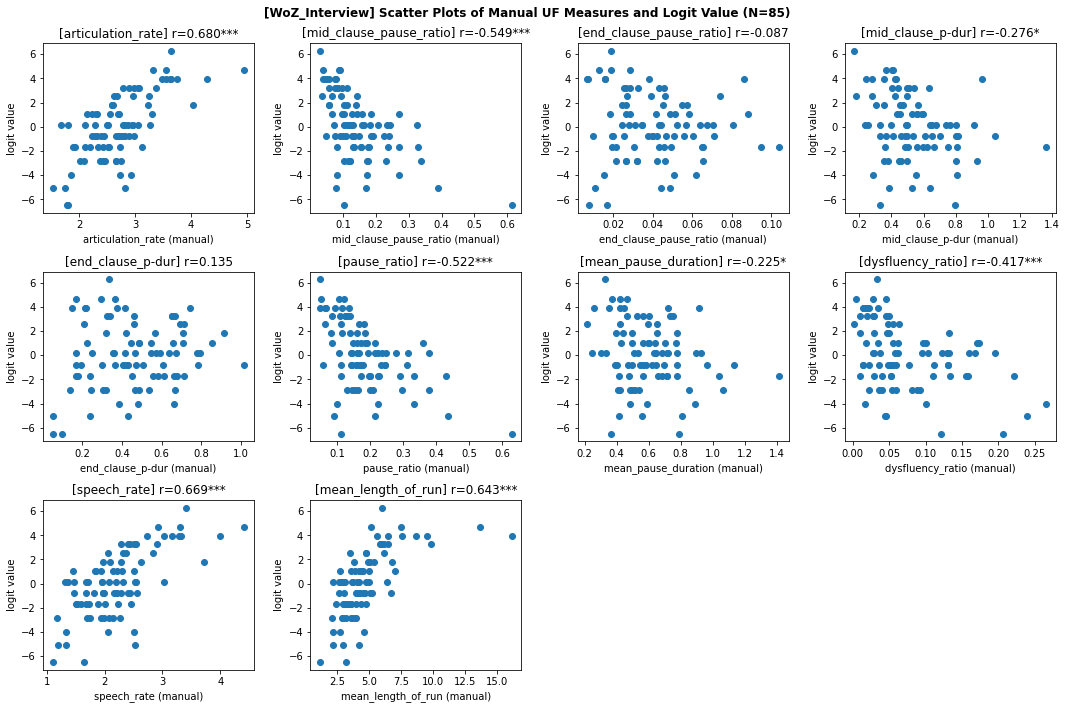

,r,p,sig
UF measures,,,
articulation_rate,0.680320,7.982105e-13,***
mid_clause_pause_ratio,-0.549138,5.270314e-08,***
end_clause_pause_ratio,-0.086843,4.293571e-01,
mid_clause_p-dur,-0.276029,1.055599e-02,*
end_clause_p-dur,0.135394,2.166478e-01,
pause_ratio,-0.521800,3.037354e-07,***
mean_pause_duration,-0.224698,3.869102e-02,*
dysfluency_ratio,-0.417166,7.132862e-05,***
speech_rate,0.669202,2.543385e-12,***


In [39]:
task = "WoZ_Interview"
manual = True
task_facet = False
X, Y = load_dataset(task, manual, task_facet)
correlation_analysis(task, X, Y, manual)

/home/matsuura/Applications/anaconda3/envs/teai-incremental-classifier/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


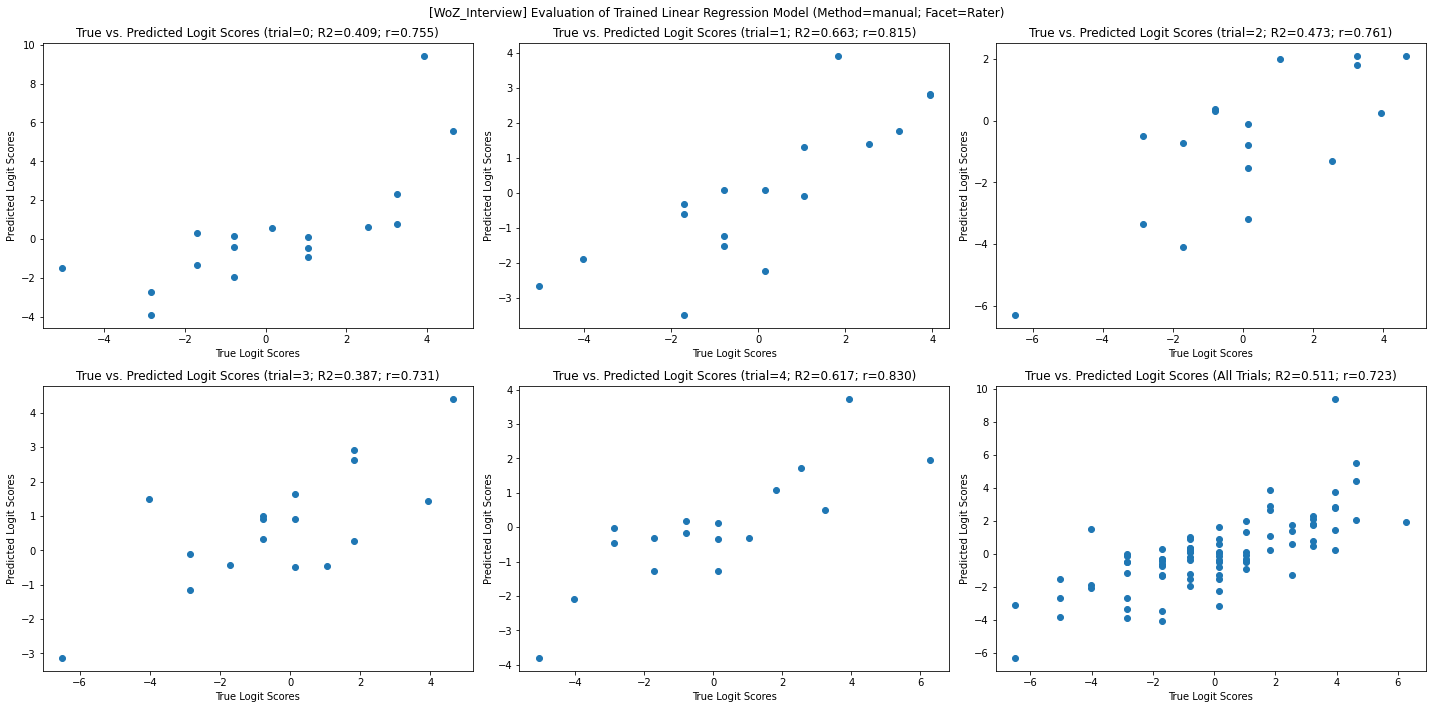

,task,method,facet,score,R2_lower,R2,R2_upper,r,articulation_rate_relimp_raw,articulation_rate_relimp_norm,...,mean_pause_duration_coef,dysfluency_ratio_relimp_raw,dysfluency_ratio_relimp_norm,dysfluency_ratio_coef,speech_rate_relimp_raw,speech_rate_relimp_norm,speech_rate_coef,mean_length_of_run_relimp_raw,mean_length_of_run_relimp_norm,mean_length_of_run_coef
name,,,,,,,,,,,,,,,,,,,,,
0 trial,WoZ_Interview,manual,Rater,0.666110,0.289337,0.408867,0.528396,0.755496,0.165226,23.021976,...,-5.305137,0.016984,2.366508,-1.916409,0.039821,5.548509,3.689510,0.119584,16.662320,0.557693
1 trial,WoZ_Interview,manual,Rater,0.632488,0.576422,0.663164,0.749906,0.814779,0.146928,22.119316,...,-4.868038,0.014038,2.113281,-7.772407,0.032640,4.913825,5.847954,0.126648,19.066201,0.378008
2 trial,WoZ_Interview,manual,Rater,0.669857,0.358189,0.472821,0.587453,0.760811,0.151987,22.476682,...,-9.974615,0.016623,2.458353,-6.182826,0.026231,3.879194,3.950726,0.100374,14.843852,0.474349
3 trial,WoZ_Interview,manual,Rater,0.675439,0.266531,0.387117,0.507704,0.731163,4.727795,4.104645,...,-6.142414,2.841396,2.466884,-9.661677,6.976317,6.056799,3.839450,6.879050,5.972352,0.385204
4 trial,WoZ_Interview,manual,Rater,0.642059,0.521842,0.616980,0.712119,0.829570,0.155632,22.834500,...,-8.566841,0.021175,3.106846,-5.082600,0.031048,4.555439,4.269002,0.116335,17.068762,0.453643
Average,WoZ_Interview,manual,Rater,NaN,0.402464,0.509790,0.617116,0.778364,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Concat,WoZ_Interview,manual,Rater,NaN,0.380994,0.510795,0.640595,0.722604,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
results, train_indices_list_woz, test_indices_list_woz = train(X, Y)
df_eval = evaluate(task, results, manual, task_facet)
df_eval_list.append(df_eval)
df_eval

**Automatic Measures (Facet = Rater)**

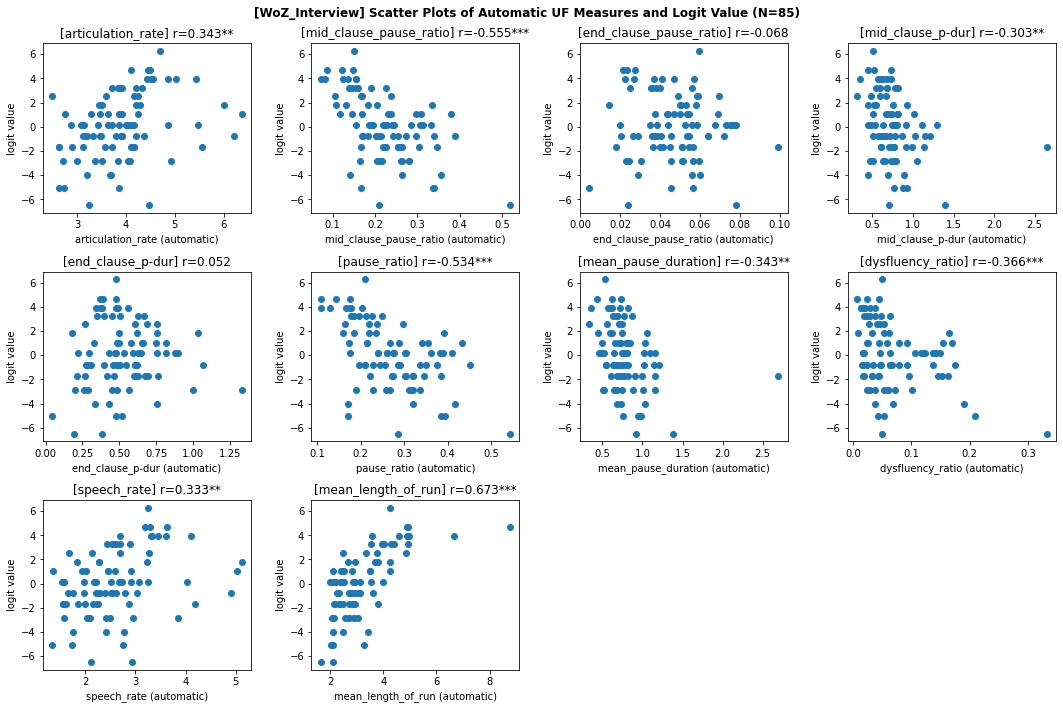

,r,p,sig
UF measures,,,
articulation_rate,0.343205,1.301686e-03,**
mid_clause_pause_ratio,-0.555233,3.489938e-08,***
end_clause_pause_ratio,-0.067940,5.366995e-01,
mid_clause_p-dur,-0.302945,4.829262e-03,**
end_clause_p-dur,0.051954,6.367684e-01,
pause_ratio,-0.533817,1.433475e-07,***
mean_pause_duration,-0.343068,1.307887e-03,**
dysfluency_ratio,-0.365968,5.723096e-04,***
speech_rate,0.332818,1.856788e-03,**


In [41]:
task = "WoZ_Interview"
manual = False
task_facet = False
X, Y = load_dataset(task, manual, task_facet)
correlation_analysis(task, X, Y, manual)

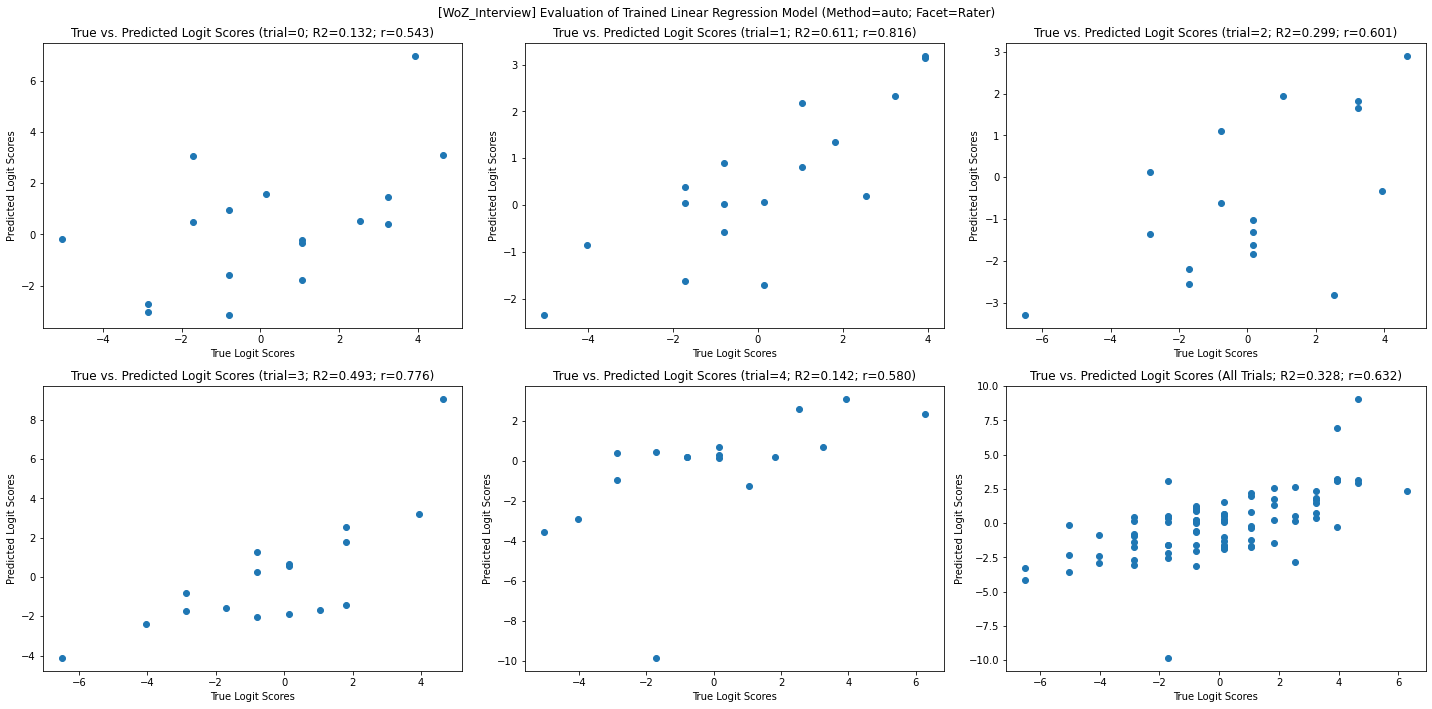

,task,method,facet,score,R2_lower,R2,R2_upper,r,articulation_rate_relimp_raw,articulation_rate_relimp_norm,...,mean_pause_duration_coef,dysfluency_ratio_relimp_raw,dysfluency_ratio_relimp_norm,dysfluency_ratio_coef,speech_rate_relimp_raw,speech_rate_relimp_norm,speech_rate_coef,mean_length_of_run_relimp_raw,mean_length_of_run_relimp_norm,mean_length_of_run_coef
name,,,,,,,,,,,,,,,,,,,,,
0 trial,WoZ_Interview,auto,Rater,0.676673,0.032265,0.131988,0.231710,0.543204,2.018501e-01,29.796006,...,-14.454737,2.110610e-02,3.115567,6.983855,5.335580e-02,7.876090,-1.680304,3.590660e-02,5.300336,1.100787
1 trial,WoZ_Interview,auto,Rater,0.594859,0.515356,0.611437,0.707518,0.816000,2.015290e-01,29.979070,...,-15.561175,1.963542e-02,2.920928,-5.875268,4.369129e-02,6.499433,-0.670698,2.864624e-02,4.261360,1.270653
2 trial,WoZ_Interview,auto,Rater,0.655429,0.178253,0.299481,0.420710,0.601295,4.068643e+25,12.539660,...,-15.117040,4.344211e+24,1.338897,1.730774,1.414751e+25,4.360297,-0.337469,1.136140e+25,3.501613,1.344711
3 trial,WoZ_Interview,auto,Rater,0.594424,0.380291,0.492877,0.605463,0.775511,2.024021e-01,27.202379,...,-12.365236,3.375370e-02,4.536420,-3.621771,5.018229e-02,6.744386,-0.424637,4.745625e-02,6.378012,1.704646
4 trial,WoZ_Interview,auto,Rater,0.634548,0.039952,0.142256,0.244560,0.580119,6.314749e-01,4.849172,...,-15.539964,4.947482e-01,3.799231,-0.246973,8.386397e-01,6.440015,-0.726348,1.901736e-01,1.460366,1.115460
Average,WoZ_Interview,auto,Rater,NaN,0.229224,0.335608,0.441992,0.663226,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Concat,WoZ_Interview,auto,Rater,NaN,0.184935,0.327812,0.470690,0.631748,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
results, _, _ = train(X, Y, train_indices_list_woz, test_indices_list_woz)
df_eval = evaluate(task, results, manual, task_facet)
df_eval_list.append(df_eval)
df_eval

### 3.6. Summary

In [43]:
df_all_eval = pd.concat(df_eval_list)
df_all_eval.to_csv("/home/matsuura/Development/app/feature_extraction_api/experiment/data/prediction_all_results.csv")
df_all_eval

,task,method,facet,score,R2_lower,R2,R2_upper,r,articulation_rate_relimp_raw,articulation_rate_relimp_norm,...,mean_pause_duration_coef,dysfluency_ratio_relimp_raw,dysfluency_ratio_relimp_norm,dysfluency_ratio_coef,speech_rate_relimp_raw,speech_rate_relimp_norm,speech_rate_coef,mean_length_of_run_relimp_raw,mean_length_of_run_relimp_norm,mean_length_of_run_coef
name,,,,,,,,,,,,,,,,,,,,,
0 trial,Arg_Oly,manual,Rater,0.765375,0.545007,0.662748,0.780489,0.817080,9.541854e-02,11.321626,...,-0.202067,3.590373e-02,4.260059,-0.900166,3.294508e-02,3.909009,1.779387,2.553477e-01,30.297582,-0.035809
1 trial,Arg_Oly,manual,Rater,0.749605,0.603526,0.708693,0.813860,0.850426,9.829618e-02,11.535978,...,-0.760176,4.024104e-02,4.722663,-0.914623,3.346155e-02,3.927026,1.482920,2.603774e-01,30.557725,-0.019697
2 trial,Arg_Oly,manual,Rater,0.726763,0.706829,0.787649,0.868470,0.919893,3.429216e-01,25.754007,...,-1.268724,7.075431e-02,5.313772,-0.363413,3.528355e-02,2.649856,0.735342,2.461311e-01,18.484875,0.102501
3 trial,Arg_Oly,manual,Rater,0.776214,0.438533,0.575055,0.711578,0.771854,9.946806e-02,11.834527,...,0.255583,3.667818e-02,4.363903,-0.500937,2.950195e-02,3.510088,1.615301,2.388005e-01,28.412048,0.021873
4 trial,Arg_Oly,manual,Rater,0.745432,0.650428,0.743983,0.837538,0.872465,8.195690e+00,4.184864,...,-1.044775,1.169570e+00,0.597203,-1.143247,1.511704e+01,7.719028,1.285608,1.710874e+01,8.736025,-0.009067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2 trial,WoZ_Interview,auto,Rater,0.655429,0.178253,0.299481,0.420710,0.601295,4.068643e+25,12.539660,...,-15.117040,4.344211e+24,1.338897,1.730774,1.414751e+25,4.360297,-0.337469,1.136140e+25,3.501613,1.344711
3 trial,WoZ_Interview,auto,Rater,0.594424,0.380291,0.492877,0.605463,0.775511,2.024021e-01,27.202379,...,-12.365236,3.375370e-02,4.536420,-3.621771,5.018229e-02,6.744386,-0.424637,4.745625e-02,6.378012,1.704646
4 trial,WoZ_Interview,auto,Rater,0.634548,0.039952,0.142256,0.244560,0.580119,6.314749e-01,4.849172,...,-15.539964,4.947482e-01,3.799231,-0.246973,8.386397e-01,6.440015,-0.726348,1.901736e-01,1.460366,1.115460


The following code block saves tran and test indices for the replicable studies.

In [44]:
train_test_indices = {
    "monologue": {
        "train": train_indices_list,
        "test": test_indices_list
    },
    "dialogue": {
        "train": train_indices_list_woz,
        "test": test_indices_list_woz
    }
}

save_path = "/home/matsuura/Development/app/feature_extraction_api/experiment/data/train_test_indices.pkl"
with open(save_path, "wb") as f:
    pkl.dump(train_test_indices, f)

In [45]:
train_indices_list

[array([  1,   2,   3,   4,   5,   7,   9,  11,  12,  13,  14,  15,  16,
         19,  20,  23,  24,  25,  26,  28,  29,  30,  31,  32,  33,  34,
         35,  36,  37,  38,  40,  41,  42,  44,  45,  46,  47,  48,  49,
         50,  51,  52,  53,  54,  55,  56,  57,  58,  60,  61,  62,  64,
         65,  66,  67,  68,  69,  71,  72,  73,  76,  77,  78,  79,  80,
         82,  84,  85,  86,  87,  88,  89,  90,  92,  93,  94,  95,  97,
         99, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
        113, 114, 115, 116, 118, 121, 122, 123, 124, 125, 126]),
 array([  0,   1,   3,   4,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  26,  27,  28,
         29,  30,  31,  34,  35,  37,  38,  39,  40,  41,  43,  44,  45,
         46,  47,  48,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
         60,  61,  63,  64,  65,  67,  68,  70,  74,  75,  76,  77,  78,
         80,  81,  82,  83,  84,  86,  87,  88,  89,  90,  